## Recurrent Neural Network (RNN) model 

In [1]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
    
import os
SAVING_DIR = r'C:\Users\Rabbil\Documents\BDA_thesis\thesis-project\outputs\models'

import pandas as pd
import seaborn as sns
import numpy as np

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.layers import Dropout

from sklearn.preprocessing import RobustScaler, MinMaxScaler

from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

import sklearn.metrics as metrics # for model evaluation 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
df_by_hour = pd.read_csv(r'C:\Users\Rabbil\Documents\BDA_thesis\thesis-project\data\processed\cleaned_df_final.csv').drop(['index'], axis=1)
df_by_hour.head(2)

,date,Pressure,Humidity,Temperature,NO_s,NO2_s,O3_s,CO_s,NO,NO2,...,CO_rolling_min,O3_rolling_min,NO_rolling_max,NO2_rolling_max,CO_rolling_max,O3_rolling_max,NO_rolling_std,NO2_rolling_std,CO_rolling_std,O3_rolling_std
0,2019-03-01 06:00:00,100619.981389,19.921558,12.797778,0.070146,0.002855,0.059470,0.062104,0.010423,0.002472,...,0.029785,0.000218,0.079813,0.007066,0.195127,0.011892,0.010128,0.001182,0.017390,0.003126
1,2019-03-01 07:00:00,100585.411944,23.175349,9.847472,0.053864,0.002855,0.059185,0.029971,0.009536,0.002502,...,0.029785,0.000218,0.079813,0.007066,0.195127,0.011892,0.010123,0.001187,0.017379,0.003055


In [3]:
df_by_hour.set_index('date', inplace=True)
df_by_hour.head(2)

,Pressure,Humidity,Temperature,NO_s,NO2_s,O3_s,CO_s,NO,NO2,O3,...,CO_rolling_min,O3_rolling_min,NO_rolling_max,NO2_rolling_max,CO_rolling_max,O3_rolling_max,NO_rolling_std,NO2_rolling_std,CO_rolling_std,O3_rolling_std
date,,,,,,,,,,,,,,,,,,,,,
2019-03-01 06:00:00,100619.981389,19.921558,12.797778,0.070146,0.002855,0.059470,0.062104,0.010423,0.002472,0.000708,...,0.029785,0.000218,0.079813,0.007066,0.195127,0.011892,0.010128,0.001182,0.017390,0.003126
2019-03-01 07:00:00,100585.411944,23.175349,9.847472,0.053864,0.002855,0.059185,0.029971,0.009536,0.002502,0.000517,...,0.029785,0.000218,0.079813,0.007066,0.195127,0.011892,0.010123,0.001187,0.017379,0.003055


In [4]:
# sub-selecting data 
df_by_hour= df_by_hour.loc['2019-03':'2019-06']
df_by_hour.drop(['Day'], axis=1, inplace =True)

In [5]:
df_by_hour.columns

Index(['Pressure', 'Humidity', 'Temperature', 'NO_s', 'NO2_s', 'O3_s', 'CO_s',
       'NO', 'NO2', 'O3', 'CO', 'Hour', 'Day_of_week', 'Day_of_month', 'Month',
       'is_weekday', 'daypart', 'Season', 'NO_lag_feature', 'NO2_lag_feature',
       'CO_lag_feature', 'O3_lag_feature', 'NO_rolling_mean',
       'NO2_rolling_mean', 'CO_rolling_mean', 'O3_rolling_mean',
       'NO_rolling_min', 'NO2_rolling_min', 'CO_rolling_min', 'O3_rolling_min',
       'NO_rolling_max', 'NO2_rolling_max', 'CO_rolling_max', 'O3_rolling_max',
       'NO_rolling_std', 'NO2_rolling_std', 'CO_rolling_std',
       'O3_rolling_std'],
      dtype='object')

### Machine learning data preparation 

In [6]:
# Spliting the data into train and test sets
train_size = int(len(df_by_hour)*0.8)
test_size = len(df_by_hour) - train_size

train, test = df_by_hour.iloc[0:train_size], df_by_hour.iloc[train_size:len(df_by_hour)]

print(train.shape, test.shape)

(1761, 38) (441, 38)


In [7]:
# Scaling of data

# creating variables for list of columns with scaler
feature_columns = ['Pressure', 'Humidity', 'Temperature','NO', 'NO2', 'CO',
         'NO_s', 'NO2_s','O3_s', 'CO_s', 'Hour','Day_of_week', 'is_weekday', 'daypart',
        'NO_rolling_mean', 'NO2_rolling_mean', 'CO_rolling_mean',
        'O3_rolling_mean', 'NO_rolling_min', 'NO2_rolling_min',
        'CO_rolling_min', 'O3_rolling_min', 'NO_rolling_max', 'NO2_rolling_max',
        'CO_rolling_max', 'O3_rolling_max',
        'O3_rolling_std']
#target_columns = ['NO']

feature_transformer = MinMaxScaler()
NO_transformer = MinMaxScaler()

# fit the scaler on training data
feature_transformer = feature_transformer.fit(train[feature_columns])
NO_transformer = NO_transformer.fit(train[['NO']])

In [8]:
train.loc[:, feature_columns] = feature_transformer.transform(train[feature_columns])
train['NO'] = NO_transformer.transform(train[['NO']])

test.loc[:, feature_columns] = feature_transformer.transform(test[feature_columns])
test['NO'] = NO_transformer.transform(test[['NO']])

In [9]:
# Making the time series data into sub sequences by writing a funciton
# split a multivariate sequene into samples
import numpy as np 
def create_dataset(X, y, time_steps=1): # X=features, y=labels, time_steps= history of sequence
    Xs, ys = [], [] # create two lists
    for i in range(len(X) - time_steps): #loops for the subsequent steps
        values = X.iloc[i: (i + time_steps)]
        Xs.append(values)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

#x = np.asarray(x).astype('float32')
#x_train = np.asarray(x_train).astype(np.float32)
#y_train = np.asarray(y_train).astype(np.float32)

In [10]:
# Specify number of time steps
TIME_STEPS = 48 # history of 24 hours to predict for the next 24 hours

# Creating actual taining and test dataset
# Reshaping to samples, time_steps and n_features
X_train, y_train = create_dataset(train, train.NO, time_steps= TIME_STEPS)
X_test, y_test = create_dataset(test, test.NO, time_steps= TIME_STEPS)

In [11]:
# printing number of samples, number of time_steps and number of features
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1713, 48, 38) (1713,)
(393, 48, 38) (393,)


In [12]:
# print the first sequence
#X_test[0].shape
X_test[0][0].shape, X_train[0][0].shape

((38,), (38,))

In [13]:
# Function for creating deep learning model

def create_model(optimizer='adam', dropout_rate=0.2, activation='relu'):
    model_rnn = keras.Sequential()

    model_rnn.add( keras.layers.SimpleRNN(units = 128, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model_rnn.add(keras.layers.Dropout(rate=0.2))# add dropout layer

    model_rnn.add(Dense(8, activation='relu'))

    model_rnn.add(keras.layers.Dense(units=1))

    # compile the model
    model_rnn.compile(loss='mean_squared_error', optimizer='RMSProp')
    return model_rnn

model_rnn = create_model()
model_rnn.summary()

# Saving the model
my_path = SAVING_DIR
my_file = "model_rnn.h5"
model_rnn.save_weights(os.path.join(my_path, my_file))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 128)               21376     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 8)                 1032      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 22,417
Trainable params: 22,417
Non-trainable params: 0
_________________________________________________________________


In [14]:
%%time
seed = 7
np.random.seed(seed)

rnn_history = model_rnn.fit(X_train, y_train, 
                        epochs = 40,
                        batch_size=16,
                        validation_split=0.3,
                        shuffle=False
                       )

Train on 1199 samples, validate on 514 samples
Epoch 1/40
1199/1199 [==============================] - 7s 6ms/sample - loss: 2.4119 - val_loss: 0.6189
Epoch 2/40
1199/1199 [==============================] - 3s 2ms/sample - loss: 1.7438 - val_loss: 0.4779
Epoch 3/40
1199/1199 [==============================] - 2s 2ms/sample - loss: 1.1360 - val_loss: 0.4183
Epoch 4/40
1199/1199 [==============================] - 2s 2ms/sample - loss: 0.8474 - val_loss: 0.3513
Epoch 5/40
1199/1199 [==============================] - 2s 2ms/sample - loss: 0.7561 - val_loss: 0.3032
Epoch 6/40
1199/1199 [==============================] - 3s 2ms/sample - loss: 0.6653 - val_loss: 0.4668
Epoch 7/40
1199/1199 [==============================] - 3s 2ms/sample - loss: 0.5933 - val_loss: 0.3717
Epoch 8/40
1199/1199 [==============================] - 3s 2ms/sample - loss: 0.5592 - val_loss: 0.5382
Epoch 9/40
1199/1199 [==============================] - 3s 2ms/sample - loss: 0.5242 - val_loss: 0.3374
Epoch 10/40
1199/

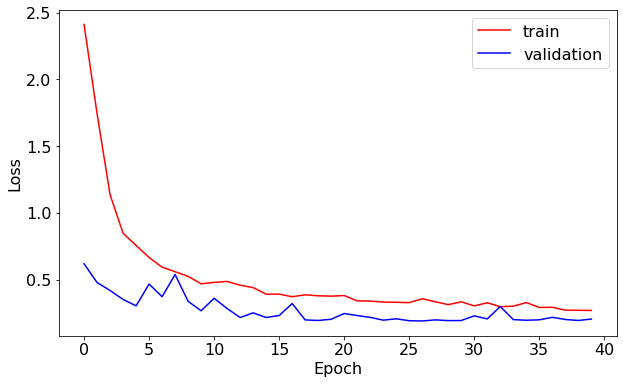

In [16]:
# Plot the loss function
fig, ax = plt.subplots(1, 1, figsize=(10,6))
plt.plot(rnn_history.history['loss'], 'r', label='train')
plt.plot(rnn_history.history['val_loss'], 'b', label='validation')
ax.set_xlabel(r'Epoch', fontsize=16)
ax.set_ylabel(r'Loss', fontsize=16)
ax.legend(fontsize = 16)
ax.tick_params(labelsize=16)


# Save the plot
my_path = SAVING_DIR
my_file = 'RNN_model_NO.png'
plt.savefig(os.path.join(my_path, my_file))

In [17]:
# making prediction
y_pred_rnn = model_rnn.predict(X_test)

In [18]:
# function for calculating MAPE
def mape(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual))*100

# Model evaluation using mean square error (MSE)
print('r Squared Error:' , metrics.r2_score(y_test, y_pred_rnn))
print('Mean Squared Error:' , metrics.mean_squared_error(y_test, y_pred_rnn))
# Model evaluation using  root mean squared error (RMSE): value 1 deptics worst model
print('Root Mean Squared Error:' , np.sqrt(metrics.mean_squared_error(y_test, y_pred_rnn)))
# Model evaluation using mean absolute error (MAE): value 0 deptics best model
print('Mean Absolute Error:' , metrics.mean_absolute_error(y_test, y_pred_rnn))
print('MAPE:' , mape(y_test, y_pred_rnn))

r Squared Error: 0.8867505535450767
Mean Squared Error: 0.4830306644904956
Root Mean Squared Error: 0.695004075161071
Mean Absolute Error: 0.3794695046702402
MAPE: 144.53353029277537


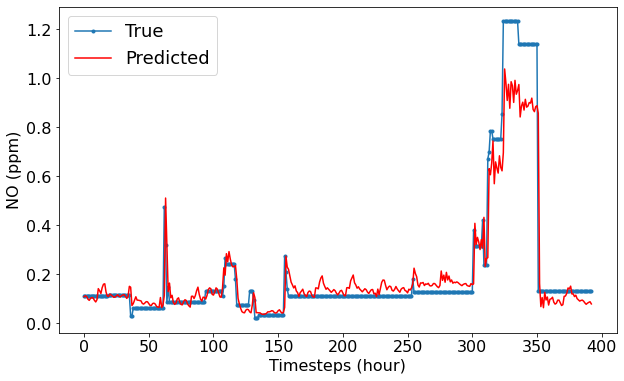

In [19]:
# use inverse the scaler for the feature variable
# invert the X_train, y_train and predicted data
y_train_inv = NO_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = NO_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = NO_transformer.inverse_transform(y_pred_rnn)

# plotting the predicted value
fig, ax = plt.subplots(1, 1, figsize=(10,6))
plt.plot(y_test_inv.flatten(), marker='.', label='True')
plt.plot(y_pred_inv.flatten(), 'r', label='Predicted')

ax.set_xlabel(r'Timesteps (hour)', fontsize=16)
ax.set_ylabel(r'NO (ppm)', fontsize=16)
ax.legend()
ax.tick_params(labelsize=16)
#plt.ylabel('Global_active_power', size=15)
#plt.xlabel('Time step', size=15)
plt.legend(fontsize=18)

my_path = SAVING_DIR
my_file = 'RNN_prediction_NO'
plt.savefig(os.path.join(my_path, my_file), dpi=300, bbox_inches='tight')

### Tunning hyperparameter using cross vlaidation : by using GridSearchCV from Scikit-Learn

In [29]:
%%time
seed = 7 # fix random seed for reproducibility
np.random.seed(seed)


# create the sklearn model for the network
model_batch_epoch = KerasRegressor(build_fn=create_model, verbose=1)

# we choose the initializers that came at the top in our previous cross-validation!!
#init_mode = ['glorot_uniform', 'uniform'] 
#layer_size= [32, 64, 128]
batches = [16, 32, 64]
epochs = [20, 30, 40]
#learn_rate= [0.001,0.01, 0.1 ]
dropout_rate=[0.2, 0.3]
optimizer=['Adam', 'RMSProp']
#activation=['sigmoid', 'relu']

# grid search for initializer
param_grid = dict( batch_size=batches, epochs=epochs, dropout_rate=dropout_rate, optimizer=optimizer)
grid = GridSearchCV(estimator=model_batch_epoch,
                    param_grid=param_grid,
                    cv=3)
grid_result = grid.fit(X_train, y_train)

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 4s 3ms/sample - loss: 1.6907
Epoch 2/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.7031
Epoch 3/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.5397
Epoch 4/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5173 0s - loss:  - ETA: 0s - loss: 0.51
Epoch 5/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4503
Epoch 6/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.4363
Epoch 7/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.4052
Epoch 8/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.3824
Epoch 9/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.4085
Epoch 10/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.3636
Epoch 11/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.3714
Epoch 

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 4s 3ms/sample - loss: 1.5013
Epoch 2/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.5637
Epoch 3/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.4745
Epoch 4/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4086 0s - loss: 0.4
Epoch 5/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.3732 0s - lo
Epoch 6/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.3034 0s - l
Epoch 7/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.2930 1
Epoch 8/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.2808
Epoch 9/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.2721
Epoch 10/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.2694
Epoch 11/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.2612
Epoch 12/

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 4s 3ms/sample - loss: 2.0620
Epoch 2/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.8114
Epoch 3/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.6087
Epoch 4/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5271
Epoch 5/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.4768
Epoch 6/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.4492
Epoch 7/20
1142/1142 [==============================] - ETA: 0s - loss: 0.428 - 2s 1ms/sample - loss: 0.4223
Epoch 8/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.4062
Epoch 9/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.4144
Epoch 10/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.3682
Epoch 11/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.3881
Epoch 12/20
1142/

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 4s 3ms/sample - loss: 1.1434 1s - loss
Epoch 2/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.7299
Epoch 3/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.6081
Epoch 4/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.5571
Epoch 5/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.5199
Epoch 6/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.4630
Epoch 7/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.4578
Epoch 8/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.4341
Epoch 9/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.4046
Epoch 10/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.4034
Epoch 11/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.3701
Epoch 12/20
1142/1142 [========

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 4s 3ms/sample - loss: 1.9711
Epoch 2/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.5928
Epoch 3/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.4561
Epoch 4/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.4102
Epoch 5/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.3244
Epoch 6/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.3264
Epoch 7/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.2987
Epoch 8/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.2743
Epoch 9/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.2537
Epoch 10/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.2531
Epoch 11/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.2571
Epoch 12/20
1142/1142 [==================

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 4s 3ms/sample - loss: 1.7607
Epoch 2/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.8144
Epoch 3/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.6932
Epoch 4/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.5554
Epoch 5/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.5249
Epoch 6/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.4695
Epoch 7/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.4069
Epoch 8/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.3859 
Epoch 9/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.4304
Epoch 10/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4096
Epoch 11/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3861
Epoch 12/20
1142/1142 [=================

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 4s 3ms/sample - loss: 2.0197 0s - loss: 
Epoch 2/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.7965 0s - l
Epoch 3/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.5833
Epoch 4/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.5664
Epoch 5/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.4722
Epoch 6/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.4184
Epoch 7/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.4445
Epoch 8/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.4262
Epoch 9/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.4020
Epoch 10/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.3968
Epoch 11/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.3660
Epoch 12/30
1142/1142 

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 4s 3ms/sample - loss: 1.2911
Epoch 2/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.5564
Epoch 3/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.3987
Epoch 4/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.3525
Epoch 5/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.3214
Epoch 6/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.3091
Epoch 7/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.2913
Epoch 8/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.2695
Epoch 9/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.2659
Epoch 10/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2382
Epoch 11/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.2462
Epoch 12/30
1142/1142 [==================

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 4s 3ms/sample - loss: 1.5901
Epoch 2/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.8480
Epoch 3/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.6414
Epoch 4/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5487 1
Epoch 5/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4729 0s - loss: 
Epoch 6/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4393
Epoch 7/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4078
Epoch 8/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4130
Epoch 9/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4050
Epoch 10/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3756
Epoch 11/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3490
Epoch 12/30
1142/1142 [====

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 4s 4ms/sample - loss: 2.2927
Epoch 2/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.2279
Epoch 3/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.9107
Epoch 4/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.7507
Epoch 5/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.6595 
Epoch 6/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5815ETA: 0s - loss: 0.
Epoch 7/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5083
Epoch 8/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5183
Epoch 9/30
1142/1142 [==============================] - 1s 1ms/sample - loss: 0.4705 0s - loss
Epoch 10/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4434
Epoch 11/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4240
Epoch 12/30


Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 4s 3ms/sample - loss: 1.5935
Epoch 2/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.6613
Epoch 3/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.5113
Epoch 4/30
1142/1142 [==============================] - 1s 1ms/sample - loss: 0.4277
Epoch 5/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.3611
Epoch 6/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3200
Epoch 7/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3033
Epoch 8/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2747
Epoch 9/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2481
Epoch 10/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2497
Epoch 11/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2333
Epoch 12/30
1142/1142 [==================

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 4s 4ms/sample - loss: 1.8546
Epoch 2/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.8831
Epoch 3/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.6317
Epoch 4/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5553
Epoch 5/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4843
Epoch 6/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4519
Epoch 7/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4246 0s - loss: 0.4
Epoch 8/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3935
Epoch 9/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3707
Epoch 10/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4008
Epoch 11/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3528
Epoch 12/30
1142/1142 [===

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 4s 4ms/sample - loss: 1.8562
Epoch 2/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.7806 1
Epoch 3/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.6477
Epoch 4/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5506
Epoch 5/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4893
Epoch 6/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4704
Epoch 7/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4479
Epoch 8/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3960
Epoch 9/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3936
Epoch 10/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4128
Epoch 11/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3787
Epoch 12/40
1142/1142 [================

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 4s 4ms/sample - loss: 1.3613
Epoch 2/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5849
Epoch 3/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4085
Epoch 4/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3621 0s - 
Epoch 5/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3197
Epoch 6/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3002 0s - los
Epoch 7/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2893
Epoch 8/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2632
Epoch 9/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.2737
Epoch 10/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2568
Epoch 11/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2730
Epoch 12/40
1142/1142 [===

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 4s 3ms/sample - loss: 1.2826
Epoch 2/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.6137
Epoch 3/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5855
Epoch 4/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5058
Epoch 5/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4404
Epoch 6/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4377
Epoch 7/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3953 0s - los
Epoch 8/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3997
Epoch 9/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3860
Epoch 10/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3788
Epoch 11/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3351
Epoch 12/40
1142/1142 [=========

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 4s 3ms/sample - loss: 1.4920
Epoch 2/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.8354
Epoch 3/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.6356
Epoch 4/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5568
Epoch 5/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5246
Epoch 6/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4601
Epoch 7/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4619
Epoch 8/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4352
Epoch 9/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4232
Epoch 10/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3936
Epoch 11/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4182
Epoch 12/40
1142/1142 [==================

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 4s 3ms/sample - loss: 1.2245
Epoch 2/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.6090
Epoch 3/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4795
Epoch 4/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3759
Epoch 5/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3711 0s - loss: 0.375
Epoch 6/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3282
Epoch 7/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3121
Epoch 8/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3014
Epoch 9/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2796 0s - loss: 
Epoch 10/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2730
Epoch 11/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2804
Epoch 12/40


Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 4s 3ms/sample - loss: 1.5263
Epoch 2/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.7255
Epoch 3/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.6105
Epoch 4/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5564
Epoch 5/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4560
Epoch 6/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4576
Epoch 7/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4082
Epoch 8/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4048
Epoch 9/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3626
Epoch 10/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3897
Epoch 11/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3523
Epoch 12/40
1142/1142 [==================

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 4s 4ms/sample - loss: 1.8659 1s - loss
Epoch 2/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.8492
Epoch 3/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.6202
Epoch 4/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5884
Epoch 5/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5106
Epoch 6/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4713
Epoch 7/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4421
Epoch 8/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4450
Epoch 9/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4184 1s - loss - ETA:
Epoch 10/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3896
Epoch 11/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3923
Epoch 12/20
11

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 4s 3ms/sample - loss: 1.5445
Epoch 2/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.6165
Epoch 3/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4804
Epoch 4/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3529
Epoch 5/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3194
Epoch 6/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3259 
Epoch 7/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2742
Epoch 8/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2816
Epoch 9/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2550
Epoch 10/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2585
Epoch 11/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2424 0s - lo
Epoch 12/20
1142/1142 [=========

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 4s 3ms/sample - loss: 2.3935
Epoch 2/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.8102
Epoch 3/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.6525
Epoch 4/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5063
Epoch 5/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4532
Epoch 6/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4342
Epoch 7/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4156
Epoch 8/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4293
Epoch 9/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3805
Epoch 10/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3948
Epoch 11/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3733
Epoch 12/20
1142/1142 [==================

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 4s 3ms/sample - loss: 1.5188
Epoch 2/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.7577
Epoch 3/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5778
Epoch 4/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5333
Epoch 5/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4495
Epoch 6/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4242
Epoch 7/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4313
Epoch 8/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4324
Epoch 9/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3900
Epoch 10/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3628
Epoch 11/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3808
Epoch 12/20
1142/1142 [==================

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 4s 3ms/sample - loss: 1.6478
Epoch 2/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.7067
Epoch 3/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4866
Epoch 4/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3978
Epoch 5/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3576
Epoch 6/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3159
Epoch 7/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3002
Epoch 8/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 0.2758
Epoch 9/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2627
Epoch 10/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2537
Epoch 11/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2692
Epoch 12/20
1142/1142 [==================

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 4s 3ms/sample - loss: 2.3467
Epoch 2/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.8419
Epoch 3/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.6676
Epoch 4/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5285
Epoch 5/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4805
Epoch 6/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4550
Epoch 7/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4104
Epoch 8/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4214
Epoch 9/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3896
Epoch 10/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3641
Epoch 11/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3622
Epoch 12/20
1142/1142 [==================

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 4s 4ms/sample - loss: 3.0249
Epoch 2/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.8712
Epoch 3/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.6868
Epoch 4/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5468
Epoch 5/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5121
Epoch 6/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4558 0s -
Epoch 7/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4565
Epoch 8/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4325
Epoch 9/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4205
Epoch 10/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4010
Epoch 11/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3744
Epoch 12/30
1142/1142 [=============

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 4s 3ms/sample - loss: 1.6678
Epoch 2/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.6863
Epoch 3/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4739
Epoch 4/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4306
Epoch 5/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3583
Epoch 6/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2903
Epoch 7/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2956
Epoch 8/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2931
Epoch 9/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2714
Epoch 10/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2750
Epoch 11/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.2294
Epoch 12/30
1142/1142 [==================

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 4s 3ms/sample - loss: 1.3947
Epoch 2/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.8043
Epoch 3/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5885
Epoch 4/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.5103
Epoch 5/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4901
Epoch 6/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4565
Epoch 7/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4026
Epoch 8/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.4047
Epoch 9/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3833
Epoch 10/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3639
Epoch 11/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 0.3731
Epoch 12/30
1142/1142 [==================

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 4s 3ms/sample - loss: 1.8671
Epoch 2/30
1142/1142 [==============================] - 1s 909us/sample - loss: 0.8214
Epoch 3/30
1142/1142 [==============================] - 1s 890us/sample - loss: 0.6528
Epoch 4/30
1142/1142 [==============================] - 1s 906us/sample - loss: 0.5949s - loss: 
Epoch 5/30
1142/1142 [==============================] - 1s 919us/sample - loss: 0.4772
Epoch 6/30
1142/1142 [==============================] - 1s 914us/sample - loss: 0.4630
Epoch 7/30
1142/1142 [==============================] - 1s 890us/sample - loss: 0.4063
Epoch 8/30
1142/1142 [==============================] - 1s 921us/sample - loss: 0.4173
Epoch 9/30
1142/1142 [==============================] - 1s 927us/sample - loss: 0.4222
Epoch 10/30
1142/1142 [==============================] - 1s 1ms/sample - loss: 0.3656
Epoch 11/30
1142/1142 [==============================] - 1s 910us/sample - loss: 0.4053
Epoch 12/30
1

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.0386
Epoch 2/30
1142/1142 [==============================] - 1s 955us/sample - loss: 0.5152
Epoch 3/30
1142/1142 [==============================] - 1s 789us/sample - loss: 0.4303
Epoch 4/30
1142/1142 [==============================] - 1s 756us/sample - loss: 0.3511
Epoch 5/30
1142/1142 [==============================] - 1s 759us/sample - loss: 0.3448
Epoch 6/30
1142/1142 [==============================] - 1s 812us/sample - loss: 0.2988
Epoch 7/30
1142/1142 [==============================] - 1s 792us/sample - loss: 0.2881
Epoch 8/30
1142/1142 [==============================] - 1s 799us/sample - loss: 0.2663
Epoch 9/30
1142/1142 [==============================] - 1s 779us/sample - loss: 0.2735
Epoch 10/30
1142/1142 [==============================] - 1s 788us/sample - loss: 0.2534
Epoch 11/30
1142/1142 [==============================] - 1s 785us/sample - loss: 0.2280
Epoch 12/30
1142/1142

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.8349
Epoch 2/30
1142/1142 [==============================] - 1s 863us/sample - loss: 0.8703
Epoch 3/30
1142/1142 [==============================] - 1s 795us/sample - loss: 0.6649
Epoch 4/30
1142/1142 [==============================] - 1s 794us/sample - loss: 0.5477
Epoch 5/30
1142/1142 [==============================] - 1s 775us/sample - loss: 0.4895
Epoch 6/30
1142/1142 [==============================] - 1s 752us/sample - loss: 0.4730
Epoch 7/30
1142/1142 [==============================] - 1s 757us/sample - loss: 0.4220
Epoch 8/30
1142/1142 [==============================] - 1s 758us/sample - loss: 0.4002
Epoch 9/30
1142/1142 [==============================] - 1s 781us/sample - loss: 0.4064
Epoch 10/30
1142/1142 [==============================] - 1s 761us/sample - loss: 0.3887
Epoch 11/30
1142/1142 [==============================] - 1s 755us/sample - loss: 0.3565
Epoch 12/30
1142/1142

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 1.9986
Epoch 2/40
1142/1142 [==============================] - 1s 748us/sample - loss: 0.7652
Epoch 3/40
1142/1142 [==============================] - 1s 748us/sample - loss: 0.5889
Epoch 4/40
1142/1142 [==============================] - 1s 745us/sample - loss: 0.5017
Epoch 5/40
1142/1142 [==============================] - 1s 744us/sample - loss: 0.5142
Epoch 6/40
1142/1142 [==============================] - 1s 804us/sample - loss: 0.4367
Epoch 7/40
1142/1142 [==============================] - 1s 747us/sample - loss: 0.4070
Epoch 8/40
1142/1142 [==============================] - 1s 769us/sample - loss: 0.3958
Epoch 9/40
1142/1142 [==============================] - 1s 742us/sample - loss: 0.3734
Epoch 10/40
1142/1142 [==============================] - 1s 749us/sample - loss: 0.3729
Epoch 11/40
1142/1142 [==============================] - 1s 783us/sample - loss: 0.3652
Epoch 12/40
1142/1142

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.2136
Epoch 2/40
1142/1142 [==============================] - 1s 756us/sample - loss: 0.5726
Epoch 3/40
1142/1142 [==============================] - 1s 756us/sample - loss: 0.4262
Epoch 4/40
1142/1142 [==============================] - 1s 758us/sample - loss: 0.3597
Epoch 5/40
1142/1142 [==============================] - 1s 759us/sample - loss: 0.3451
Epoch 6/40
1142/1142 [==============================] - 1s 756us/sample - loss: 0.2984
Epoch 7/40
1142/1142 [==============================] - 1s 745us/sample - loss: 0.3014
Epoch 8/40
1142/1142 [==============================] - 1s 758us/sample - loss: 0.2819
Epoch 9/40
1142/1142 [==============================] - 1s 763us/sample - loss: 0.2720
Epoch 10/40
1142/1142 [==============================] - 1s 743us/sample - loss: 0.2671
Epoch 11/40
1142/1142 [==============================] - 1s 761us/sample - loss: 0.2620
Epoch 12/40
1142/1142

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.8080
Epoch 2/40
1142/1142 [==============================] - 1s 797us/sample - loss: 0.8586
Epoch 3/40
1142/1142 [==============================] - ETA: 0s - loss: 0.631 - 1s 820us/sample - loss: 0.6369
Epoch 4/40
1142/1142 [==============================] - 1s 751us/sample - loss: 0.5428
Epoch 5/40
1142/1142 [==============================] - 1s 785us/sample - loss: 0.4951
Epoch 6/40
1142/1142 [==============================] - 1s 763us/sample - loss: 0.4859
Epoch 7/40
1142/1142 [==============================] - 1s 829us/sample - loss: 0.4462
Epoch 8/40
1142/1142 [==============================] - 1s 860us/sample - loss: 0.4109
Epoch 9/40
1142/1142 [==============================] - 1s 873us/sample - loss: 0.3720
Epoch 10/40
1142/1142 [==============================] - 1s 825us/sample - loss: 0.3694
Epoch 11/40
1142/1142 [==============================] - 1s 736us/sample - loss: 0.35

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.3602
Epoch 2/40
1142/1142 [==============================] - 1s 756us/sample - loss: 0.6844
Epoch 3/40
1142/1142 [==============================] - 1s 756us/sample - loss: 0.5972
Epoch 4/40
1142/1142 [==============================] - 1s 783us/sample - loss: 0.5192
Epoch 5/40
1142/1142 [==============================] - 1s 761us/sample - loss: 0.4556
Epoch 6/40
1142/1142 [==============================] - 1s 767us/sample - loss: 0.4331
Epoch 7/40
1142/1142 [==============================] - 1s 758us/sample - loss: 0.4052
Epoch 8/40
1142/1142 [==============================] - 1s 767us/sample - loss: 0.3897
Epoch 9/40
1142/1142 [==============================] - 1s 759us/sample - loss: 0.3821
Epoch 10/40
1142/1142 [==============================] - 1s 761us/sample - loss: 0.3571
Epoch 11/40
1142/1142 [==============================] - 1s 752us/sample - loss: 0.3771
Epoch 12/40
1142/1142

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.2221
Epoch 2/40
1142/1142 [==============================] - 1s 759us/sample - loss: 0.6159
Epoch 3/40
1142/1142 [==============================] - 1s 747us/sample - loss: 0.4766
Epoch 4/40
1142/1142 [==============================] - 1s 748us/sample - loss: 0.3982
Epoch 5/40
1142/1142 [==============================] - 1s 743us/sample - loss: 0.3548s -
Epoch 6/40
1142/1142 [==============================] - 1s 748us/sample - loss: 0.3057
Epoch 7/40
1142/1142 [==============================] - 1s 742us/sample - loss: 0.2994
Epoch 8/40
1142/1142 [==============================] - 1s 748us/sample - loss: 0.2953
Epoch 9/40
1142/1142 [==============================] - 1s 753us/sample - loss: 0.2637
Epoch 10/40
1142/1142 [==============================] - 1s 751us/sample - loss: 0.2711
Epoch 11/40
1142/1142 [==============================] - 1s 736us/sample - loss: 0.2609
Epoch 12/40
1142/1

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.6844
Epoch 2/40
1142/1142 [==============================] - 1s 780us/sample - loss: 0.8316
Epoch 3/40
1142/1142 [==============================] - 1s 758us/sample - loss: 0.6360
Epoch 4/40
1142/1142 [==============================] - 1s 756us/sample - loss: 0.5160
Epoch 5/40
1142/1142 [==============================] - 1s 747us/sample - loss: 0.4694
Epoch 6/40
1142/1142 [==============================] - 1s 753us/sample - loss: 0.4300
Epoch 7/40
1142/1142 [==============================] - 1s 753us/sample - loss: 0.4027
Epoch 8/40
1142/1142 [==============================] - 1s 737us/sample - loss: 0.4078
Epoch 9/40
1142/1142 [==============================] - 1s 901us/sample - loss: 0.3868
Epoch 10/40
1142/1142 [==============================] - 1s 764us/sample - loss: 0.3712
Epoch 11/40
1142/1142 [==============================] - 1s 735us/sample - loss: 0.3875
Epoch 12/40
1142/1142

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 1.8849
Epoch 2/20
1142/1142 [==============================] - 1s 452us/sample - loss: 1.0056
Epoch 3/20
1142/1142 [==============================] - 1s 446us/sample - loss: 0.7517
Epoch 4/20
1142/1142 [==============================] - 0s 433us/sample - loss: 0.6400
Epoch 5/20
1142/1142 [==============================] - 0s 408us/sample - loss: 0.6197
Epoch 6/20
1142/1142 [==============================] - 0s 435us/sample - loss: 0.5476
Epoch 7/20
1142/1142 [==============================] - 0s 415us/sample - loss: 0.5247
Epoch 8/20
1142/1142 [==============================] - 0s 434us/sample - loss: 0.5176
Epoch 9/20
1142/1142 [==============================] - 0s 422us/sample - loss: 0.4977
Epoch 10/20
1142/1142 [==============================] - 0s 425us/sample - loss: 0.4406
Epoch 11/20
1142/1142 [==============================] - 1s 438us/sample - loss: 0.4481
Epoch 12/20
1142/1142

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 1s 1ms/sample - loss: 2.6339
Epoch 2/20
1142/1142 [==============================] - 1s 455us/sample - loss: 0.9927
Epoch 3/20
1142/1142 [==============================] - 1s 477us/sample - loss: 0.7333
Epoch 4/20
1142/1142 [==============================] - 1s 441us/sample - loss: 0.5737
Epoch 5/20
1142/1142 [==============================] - 1s 445us/sample - loss: 0.4876
Epoch 6/20
1142/1142 [==============================] - 1s 454us/sample - loss: 0.4037
Epoch 7/20
1142/1142 [==============================] - 0s 433us/sample - loss: 0.4075
Epoch 8/20
1142/1142 [==============================] - 1s 441us/sample - loss: 0.3485
Epoch 9/20
1142/1142 [==============================] - 1s 452us/sample - loss: 0.3117
Epoch 10/20
1142/1142 [==============================] - 1s 450us/sample - loss: 0.2899
Epoch 11/20
1142/1142 [==============================] - 1s 456us/sample - loss: 0.2831
Epoch 12/20
1142/1142

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 1.6651
Epoch 2/20
1142/1142 [==============================] - 0s 437us/sample - loss: 0.8001
Epoch 3/20
1142/1142 [==============================] - 0s 434us/sample - loss: 0.6642
Epoch 4/20
1142/1142 [==============================] - 0s 436us/sample - loss: 0.5566
Epoch 5/20
1142/1142 [==============================] - 0s 437us/sample - loss: 0.4585
Epoch 6/20
1142/1142 [==============================] - 0s 436us/sample - loss: 0.4475
Epoch 7/20
1142/1142 [==============================] - 0s 436us/sample - loss: 0.4415
Epoch 8/20
1142/1142 [==============================] - 1s 447us/sample - loss: 0.4336
Epoch 9/20
1142/1142 [==============================] - 1s 461us/sample - loss: 0.4035
Epoch 10/20
1142/1142 [==============================] - 1s 444us/sample - loss: 0.3870
Epoch 11/20
1142/1142 [==============================] - 1s 439us/sample - loss: 0.3831
Epoch 12/20
1142/1142

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 1s 1ms/sample - loss: 2.0330
Epoch 2/20
1142/1142 [==============================] - 0s 437us/sample - loss: 1.2281
Epoch 3/20
1142/1142 [==============================] - 1s 438us/sample - loss: 0.9085
Epoch 4/20
1142/1142 [==============================] - 1s 458us/sample - loss: 0.8446
Epoch 5/20
1142/1142 [==============================] - 0s 434us/sample - loss: 0.6821s - loss: 0.70
Epoch 6/20
1142/1142 [==============================] - 1s 452us/sample - loss: 0.6884
Epoch 7/20
1142/1142 [==============================] - 0s 429us/sample - loss: 0.5901
Epoch 8/20
1142/1142 [==============================] - 0s 427us/sample - loss: 0.5946
Epoch 9/20
1142/1142 [==============================] - 0s 427us/sample - loss: 0.5469
Epoch 10/20
1142/1142 [==============================] - 0s 416us/sample - loss: 0.5210
Epoch 11/20
1142/1142 [==============================] - 0s 431us/sample - loss: 0.5032
Epoch 1

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 1.7080
Epoch 2/20
1142/1142 [==============================] - 1s 445us/sample - loss: 0.6085
Epoch 3/20
1142/1142 [==============================] - 1s 439us/sample - loss: 0.5284
Epoch 4/20
1142/1142 [==============================] - 1s 452us/sample - loss: 0.4854
Epoch 5/20
1142/1142 [==============================] - 1s 461us/sample - loss: 0.3714
Epoch 6/20
1142/1142 [==============================] - 0s 430us/sample - loss: 0.3511
Epoch 7/20
1142/1142 [==============================] - 1s 438us/sample - loss: 0.3243
Epoch 8/20
1142/1142 [==============================] - 1s 441us/sample - loss: 0.2934
Epoch 9/20
1142/1142 [==============================] - 1s 470us/sample - loss: 0.2924
Epoch 10/20
1142/1142 [==============================] - 1s 443us/sample - loss: 0.2856
Epoch 11/20
1142/1142 [==============================] - 0s 418us/sample - loss: 0.2773
Epoch 12/20
1142/1142

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 1s 1ms/sample - loss: 3.0906
Epoch 2/20
1142/1142 [==============================] - 0s 434us/sample - loss: 0.9777
Epoch 3/20
1142/1142 [==============================] - 0s 432us/sample - loss: 0.8464
Epoch 4/20
1142/1142 [==============================] - 1s 449us/sample - loss: 0.6413
Epoch 5/20
1142/1142 [==============================] - 0s 430us/sample - loss: 0.6582
Epoch 6/20
1142/1142 [==============================] - 1s 440us/sample - loss: 0.5200
Epoch 7/20
1142/1142 [==============================] - 1s 438us/sample - loss: 0.4839
Epoch 8/20
1142/1142 [==============================] - 0s 425us/sample - loss: 0.4812
Epoch 9/20
1142/1142 [==============================] - 0s 436us/sample - loss: 0.4474
Epoch 10/20
1142/1142 [==============================] - 1s 464us/sample - loss: 0.4069
Epoch 11/20
1142/1142 [==============================] - 1s 457us/sample - loss: 0.4244
Epoch 12/20
1142/1142

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 1.5250
Epoch 2/30
1142/1142 [==============================] - 1s 457us/sample - loss: 0.8295
Epoch 3/30
1142/1142 [==============================] - 0s 426us/sample - loss: 0.7102
Epoch 4/30
1142/1142 [==============================] - 1s 440us/sample - loss: 0.6389
Epoch 5/30
1142/1142 [==============================] - 1s 441us/sample - loss: 0.5599
Epoch 6/30
1142/1142 [==============================] - 1s 448us/sample - loss: 0.5257
Epoch 7/30
1142/1142 [==============================] - 1s 438us/sample - loss: 0.5314
Epoch 8/30
1142/1142 [==============================] - 1s 465us/sample - loss: 0.4730
Epoch 9/30
1142/1142 [==============================] - 0s 424us/sample - loss: 0.4503
Epoch 10/30
1142/1142 [==============================] - 0s 438us/sample - loss: 0.4182
Epoch 11/30
1142/1142 [==============================] - 0s 425us/sample - loss: 0.4243
Epoch 12/30
1142/1142

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 1s 1ms/sample - loss: 2.9904
Epoch 2/30
1142/1142 [==============================] - 1s 451us/sample - loss: 1.1778
Epoch 3/30
1142/1142 [==============================] - 1s 438us/sample - loss: 0.9118
Epoch 4/30
1142/1142 [==============================] - 0s 437us/sample - loss: 0.6628
Epoch 5/30
1142/1142 [==============================] - 0s 428us/sample - loss: 0.5381
Epoch 6/30
1142/1142 [==============================] - 0s 436us/sample - loss: 0.4996
Epoch 7/30
1142/1142 [==============================] - 0s 426us/sample - loss: 0.4119
Epoch 8/30
1142/1142 [==============================] - 1s 438us/sample - loss: 0.4238
Epoch 9/30
1142/1142 [==============================] - 0s 429us/sample - loss: 0.3826
Epoch 10/30
1142/1142 [==============================] - 0s 434us/sample - loss: 0.3407
Epoch 11/30
1142/1142 [==============================] - 0s 434us/sample - loss: 0.3010
Epoch 12/30
1142/1142

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 1s 1ms/sample - loss: 1.5896
Epoch 2/30
1142/1142 [==============================] - 1s 438us/sample - loss: 0.8744
Epoch 3/30
1142/1142 [==============================] - 0s 417us/sample - loss: 0.6250
Epoch 4/30
1142/1142 [==============================] - 0s 418us/sample - loss: 0.6030
Epoch 5/30
1142/1142 [==============================] - 0s 419us/sample - loss: 0.5393
Epoch 6/30
1142/1142 [==============================] - 1s 453us/sample - loss: 0.4763
Epoch 7/30
1142/1142 [==============================] - 0s 424us/sample - loss: 0.4522
Epoch 8/30
1142/1142 [==============================] - 1s 444us/sample - loss: 0.4581
Epoch 9/30
1142/1142 [==============================] - 0s 433us/sample - loss: 0.4149
Epoch 10/30
1142/1142 [==============================] - 1s 438us/sample - loss: 0.4107
Epoch 11/30
1142/1142 [==============================] - 0s 425us/sample - loss: 0.4061
Epoch 12/30
1142/1142

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 1s 1ms/sample - loss: 1.1754
Epoch 2/30
1142/1142 [==============================] - 1s 438us/sample - loss: 0.8022
Epoch 3/30
1142/1142 [==============================] - 0s 434us/sample - loss: 0.6568
Epoch 4/30
1142/1142 [==============================] - 0s 431us/sample - loss: 0.5818
Epoch 5/30
1142/1142 [==============================] - 1s 450us/sample - loss: 0.5118
Epoch 6/30
1142/1142 [==============================] - 1s 452us/sample - loss: 0.5358
Epoch 7/30
1142/1142 [==============================] - 1s 439us/sample - loss: 0.4665
Epoch 8/30
1142/1142 [==============================] - 1s 448us/sample - loss: 0.4537
Epoch 9/30
1142/1142 [==============================] - 1s 447us/sample - loss: 0.4433
Epoch 10/30
1142/1142 [==============================] - 1s 481us/sample - loss: 0.4112
Epoch 11/30
1142/1142 [==============================] - 1s 484us/sample - loss: 0.3987
Epoch 12/30
1142/1142

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 1s 1ms/sample - loss: 2.7805
Epoch 2/30
1142/1142 [==============================] - 0s 428us/sample - loss: 1.0177
Epoch 3/30
1142/1142 [==============================] - 0s 427us/sample - loss: 0.7384
Epoch 4/30
1142/1142 [==============================] - 0s 436us/sample - loss: 0.6762
Epoch 5/30
1142/1142 [==============================] - 0s 435us/sample - loss: 0.5530
Epoch 6/30
1142/1142 [==============================] - 0s 429us/sample - loss: 0.4521
Epoch 7/30
1142/1142 [==============================] - 1s 439us/sample - loss: 0.3829
Epoch 8/30
1142/1142 [==============================] - 1s 448us/sample - loss: 0.3356
Epoch 9/30
1142/1142 [==============================] - 1s 444us/sample - loss: 0.3950
Epoch 10/30
1142/1142 [==============================] - 0s 435us/sample - loss: 0.3216
Epoch 11/30
1142/1142 [==============================] - 0s 428us/sample - loss: 0.2957
Epoch 12/30
1142/1142

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 1.7435
Epoch 2/30
1142/1142 [==============================] - 0s 434us/sample - loss: 0.8703
Epoch 3/30
1142/1142 [==============================] - 0s 429us/sample - loss: 0.7354
Epoch 4/30
1142/1142 [==============================] - 0s 427us/sample - loss: 0.5746
Epoch 5/30
1142/1142 [==============================] - 0s 423us/sample - loss: 0.5179
Epoch 6/30
1142/1142 [==============================] - 1s 461us/sample - loss: 0.4697
Epoch 7/30
1142/1142 [==============================] - 1s 490us/sample - loss: 0.4531
Epoch 8/30
1142/1142 [==============================] - 1s 452us/sample - loss: 0.4180
Epoch 9/30
1142/1142 [==============================] - 0s 432us/sample - loss: 0.4106
Epoch 10/30
1142/1142 [==============================] - 0s 417us/sample - loss: 0.4242
Epoch 11/30
1142/1142 [==============================] - 1s 451us/sample - loss: 0.3860
Epoch 12/30
1142/1142

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 1s 1ms/sample - loss: 2.7652
Epoch 2/40
1142/1142 [==============================] - 0s 431us/sample - loss: 0.9756
Epoch 3/40
1142/1142 [==============================] - 1s 440us/sample - loss: 0.7932
Epoch 4/40
1142/1142 [==============================] - 1s 439us/sample - loss: 0.6419
Epoch 5/40
1142/1142 [==============================] - 0s 430us/sample - loss: 0.6175
Epoch 6/40
1142/1142 [==============================] - 0s 433us/sample - loss: 0.5540
Epoch 7/40
1142/1142 [==============================] - 0s 428us/sample - loss: 0.5327
Epoch 8/40
1142/1142 [==============================] - 1s 439us/sample - loss: 0.4985
Epoch 9/40
1142/1142 [==============================] - 1s 441us/sample - loss: 0.4659
Epoch 10/40
1142/1142 [==============================] - 1s 449us/sample - loss: 0.4274
Epoch 11/40
1142/1142 [==============================] - 1s 444us/sample - loss: 0.4636
Epoch 12/40
1142/1142

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 2s 1ms/sample - loss: 1.1140
Epoch 2/40
1142/1142 [==============================] - 0s 436us/sample - loss: 0.6213
Epoch 3/40
1142/1142 [==============================] - 1s 446us/sample - loss: 0.4841
Epoch 4/40
1142/1142 [==============================] - 0s 433us/sample - loss: 0.4797
Epoch 5/40
1142/1142 [==============================] - 1s 453us/sample - loss: 0.3541
Epoch 6/40
1142/1142 [==============================] - 0s 422us/sample - loss: 0.3527
Epoch 7/40
1142/1142 [==============================] - 1s 442us/sample - loss: 0.3477
Epoch 8/40
1142/1142 [==============================] - 1s 441us/sample - loss: 0.3240
Epoch 9/40
1142/1142 [==============================] - 0s 428us/sample - loss: 0.2856
Epoch 10/40
1142/1142 [==============================] - 0s 426us/sample - loss: 0.3058
Epoch 11/40
1142/1142 [==============================] - 0s 430us/sample - loss: 0.2778
Epoch 12/40
1142/1142

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 1s 1ms/sample - loss: 2.3132
Epoch 2/40
1142/1142 [==============================] - 1s 438us/sample - loss: 0.9592
Epoch 3/40
1142/1142 [==============================] - 1s 443us/sample - loss: 0.8251
Epoch 4/40
1142/1142 [==============================] - 1s 453us/sample - loss: 0.6228
Epoch 5/40
1142/1142 [==============================] - 1s 438us/sample - loss: 0.5655
Epoch 6/40
1142/1142 [==============================] - 1s 454us/sample - loss: 0.5028
Epoch 7/40
1142/1142 [==============================] - 1s 510us/sample - loss: 0.4544
Epoch 8/40
1142/1142 [==============================] - 1s 469us/sample - loss: 0.4560
Epoch 9/40
1142/1142 [==============================] - 1s 526us/sample - loss: 0.4052
Epoch 10/40
1142/1142 [==============================] - 1s 445us/sample - loss: 0.4136
Epoch 11/40
1142/1142 [==============================] - 0s 431us/sample - loss: 0.3921
Epoch 12/40
1142/1142

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 1s 1ms/sample - loss: 1.9033
Epoch 2/40
1142/1142 [==============================] - 0s 437us/sample - loss: 1.2237
Epoch 3/40
1142/1142 [==============================] - 0s 425us/sample - loss: 0.9626
Epoch 4/40
1142/1142 [==============================] - 1s 490us/sample - loss: 0.7761
Epoch 5/40
1142/1142 [==============================] - 1s 463us/sample - loss: 0.7004
Epoch 6/40
1142/1142 [==============================] - 1s 438us/sample - loss: 0.6566
Epoch 7/40
1142/1142 [==============================] - 1s 441us/sample - loss: 0.6511
Epoch 8/40
1142/1142 [==============================] - 0s 417us/sample - loss: 0.5439
Epoch 9/40
1142/1142 [==============================] - 0s 429us/sample - loss: 0.5503
Epoch 10/40
1142/1142 [==============================] - 1s 441us/sample - loss: 0.5067
Epoch 11/40
1142/1142 [==============================] - 1s 453us/sample - loss: 0.4893
Epoch 12/40
1142/1142

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 1s 1ms/sample - loss: 1.3970
Epoch 2/40
1142/1142 [==============================] - 1s 532us/sample - loss: 0.7119
Epoch 3/40
1142/1142 [==============================] - 1s 573us/sample - loss: 0.6027
Epoch 4/40
1142/1142 [==============================] - 0s 436us/sample - loss: 0.4013
Epoch 5/40
1142/1142 [==============================] - 0s 415us/sample - loss: 0.3831
Epoch 6/40
1142/1142 [==============================] - 0s 423us/sample - loss: 0.3477
Epoch 7/40
1142/1142 [==============================] - 0s 416us/sample - loss: 0.3348
Epoch 8/40
1142/1142 [==============================] - 0s 419us/sample - loss: 0.3034
Epoch 9/40
1142/1142 [==============================] - 1s 441us/sample - loss: 0.2942
Epoch 10/40
1142/1142 [==============================] - 0s 419us/sample - loss: 0.2945
Epoch 11/40
1142/1142 [==============================] - 0s 425us/sample - loss: 0.2459
Epoch 12/40
1142/1142

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 1s 1ms/sample - loss: 1.7619 1s - loss: 2
Epoch 2/40
1142/1142 [==============================] - 0s 431us/sample - loss: 0.9290
Epoch 3/40
1142/1142 [==============================] - 0s 424us/sample - loss: 0.7053
Epoch 4/40
1142/1142 [==============================] - 1s 438us/sample - loss: 0.5930
Epoch 5/40
1142/1142 [==============================] - 0s 418us/sample - loss: 0.5588
Epoch 6/40
1142/1142 [==============================] - 0s 436us/sample - loss: 0.4841
Epoch 7/40
1142/1142 [==============================] - 0s 437us/sample - loss: 0.5014
Epoch 8/40
1142/1142 [==============================] - 0s 431us/sample - loss: 0.4093
Epoch 9/40
1142/1142 [==============================] - 0s 434us/sample - loss: 0.4195
Epoch 10/40
1142/1142 [==============================] - 0s 413us/sample - loss: 0.4104
Epoch 11/40
1142/1142 [==============================] - 1s 440us/sample - loss: 0.3746
Epoch 12

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 4.1898
Epoch 2/20
1142/1142 [==============================] - 1s 458us/sample - loss: 1.2931
Epoch 3/20
1142/1142 [==============================] - 1s 470us/sample - loss: 0.9103
Epoch 4/20
1142/1142 [==============================] - 0s 429us/sample - loss: 0.7819
Epoch 5/20
1142/1142 [==============================] - 0s 430us/sample - loss: 0.6617
Epoch 6/20
1142/1142 [==============================] - 0s 427us/sample - loss: 0.5814
Epoch 7/20
1142/1142 [==============================] - 0s 427us/sample - loss: 0.5889
Epoch 8/20
1142/1142 [==============================] - 0s 428us/sample - loss: 0.5129
Epoch 9/20
1142/1142 [==============================] - 0s 424us/sample - loss: 0.4680
Epoch 10/20
1142/1142 [==============================] - 0s 431us/sample - loss: 0.4465
Epoch 11/20
1142/1142 [==============================] - 0s 432us/sample - loss: 0.4297
Epoch 12/20
1142/1142

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 1s 1ms/sample - loss: 1.3074
Epoch 2/20
1142/1142 [==============================] - 1s 439us/sample - loss: 0.7073
Epoch 3/20
1142/1142 [==============================] - 1s 438us/sample - loss: 0.5578
Epoch 4/20
1142/1142 [==============================] - 0s 433us/sample - loss: 0.4849
Epoch 5/20
1142/1142 [==============================] - 1s 451us/sample - loss: 0.4643
Epoch 6/20
1142/1142 [==============================] - 1s 461us/sample - loss: 0.3767
Epoch 7/20
1142/1142 [==============================] - 1s 470us/sample - loss: 0.3708
Epoch 8/20
1142/1142 [==============================] - 1s 473us/sample - loss: 0.3280
Epoch 9/20
1142/1142 [==============================] - 1s 447us/sample - loss: 0.3495
Epoch 10/20
1142/1142 [==============================] - 0s 430us/sample - loss: 0.2790
Epoch 11/20
1142/1142 [==============================] - 0s 410us/sample - loss: 0.2871
Epoch 12/20
1142/1142

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 3.2399
Epoch 2/20
1142/1142 [==============================] - 1s 463us/sample - loss: 1.2724
Epoch 3/20
1142/1142 [==============================] - 1s 481us/sample - loss: 0.9204
Epoch 4/20
1142/1142 [==============================] - 0s 428us/sample - loss: 0.8024
Epoch 5/20
1142/1142 [==============================] - 0s 420us/sample - loss: 0.6624
Epoch 6/20
1142/1142 [==============================] - 0s 421us/sample - loss: 0.5523
Epoch 7/20
1142/1142 [==============================] - 0s 420us/sample - loss: 0.5242
Epoch 8/20
1142/1142 [==============================] - 0s 414us/sample - loss: 0.5056
Epoch 9/20
1142/1142 [==============================] - 0s 410us/sample - loss: 0.4786
Epoch 10/20
1142/1142 [==============================] - 0s 435us/sample - loss: 0.4525
Epoch 11/20
1142/1142 [==============================] - 1s 455us/sample - loss: 0.3965
Epoch 12/20
1142/1142

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 2s 1ms/sample - loss: 1.9254
Epoch 2/20
1142/1142 [==============================] - 1s 463us/sample - loss: 1.2000
Epoch 3/20
1142/1142 [==============================] - 1s 439us/sample - loss: 0.8530
Epoch 4/20
1142/1142 [==============================] - 0s 421us/sample - loss: 0.6938
Epoch 5/20
1142/1142 [==============================] - 0s 425us/sample - loss: 0.5908
Epoch 6/20
1142/1142 [==============================] - 0s 431us/sample - loss: 0.5756
Epoch 7/20
1142/1142 [==============================] - 0s 428us/sample - loss: 0.5341
Epoch 8/20
1142/1142 [==============================] - 1s 441us/sample - loss: 0.5079
Epoch 9/20
1142/1142 [==============================] - 1s 485us/sample - loss: 0.4654
Epoch 10/20
1142/1142 [==============================] - 1s 438us/sample - loss: 0.4289
Epoch 11/20
1142/1142 [==============================] - 0s 425us/sample - loss: 0.4106
Epoch 12/20
1142/1142

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 1s 1ms/sample - loss: 3.3992
Epoch 2/20
1142/1142 [==============================] - 0s 428us/sample - loss: 1.0850
Epoch 3/20
1142/1142 [==============================] - 1s 441us/sample - loss: 0.7983
Epoch 4/20
1142/1142 [==============================] - 0s 435us/sample - loss: 0.7078
Epoch 5/20
1142/1142 [==============================] - 0s 437us/sample - loss: 0.5299
Epoch 6/20
1142/1142 [==============================] - 1s 440us/sample - loss: 0.4532
Epoch 7/20
1142/1142 [==============================] - 1s 441us/sample - loss: 0.4433
Epoch 8/20
1142/1142 [==============================] - 0s 415us/sample - loss: 0.4021
Epoch 9/20
1142/1142 [==============================] - 0s 423us/sample - loss: 0.3407
Epoch 10/20
1142/1142 [==============================] - 1s 445us/sample - loss: 0.3704
Epoch 11/20
1142/1142 [==============================] - 0s 429us/sample - loss: 0.3308
Epoch 12/20
1142/1142

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 2.1182
Epoch 2/20
1142/1142 [==============================] - 1s 447us/sample - loss: 0.9841
Epoch 3/20
1142/1142 [==============================] - 1s 459us/sample - loss: 0.7850
Epoch 4/20
1142/1142 [==============================] - 0s 429us/sample - loss: 0.5613
Epoch 5/20
1142/1142 [==============================] - 1s 471us/sample - loss: 0.5784
Epoch 6/20
1142/1142 [==============================] - 1s 452us/sample - loss: 0.5152
Epoch 7/20
1142/1142 [==============================] - 0s 434us/sample - loss: 0.5141
Epoch 8/20
1142/1142 [==============================] - 1s 477us/sample - loss: 0.4596
Epoch 9/20
1142/1142 [==============================] - 0s 434us/sample - loss: 0.4008
Epoch 10/20
1142/1142 [==============================] - 0s 436us/sample - loss: 0.4076
Epoch 11/20
1142/1142 [==============================] - 0s 430us/sample - loss: 0.4085
Epoch 12/20
1142/1142

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 2.1333
Epoch 2/30
1142/1142 [==============================] - 1s 481us/sample - loss: 0.9210
Epoch 3/30
1142/1142 [==============================] - 1s 468us/sample - loss: 0.7405
Epoch 4/30
1142/1142 [==============================] - 0s 435us/sample - loss: 0.7095
Epoch 5/30
1142/1142 [==============================] - 0s 437us/sample - loss: 0.5869
Epoch 6/30
1142/1142 [==============================] - 0s 426us/sample - loss: 0.5474
Epoch 7/30
1142/1142 [==============================] - 1s 444us/sample - loss: 0.5097
Epoch 8/30
1142/1142 [==============================] - 1s 441us/sample - loss: 0.5000
Epoch 9/30
1142/1142 [==============================] - 1s 443us/sample - loss: 0.4338
Epoch 10/30
1142/1142 [==============================] - 0s 433us/sample - loss: 0.4650
Epoch 11/30
1142/1142 [==============================] - 1s 464us/sample - loss: 0.4192
Epoch 12/30
1142/1142

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 1s 1ms/sample - loss: 1.1799
Epoch 2/30
1142/1142 [==============================] - 0s 424us/sample - loss: 0.6728
Epoch 3/30
1142/1142 [==============================] - 0s 424us/sample - loss: 0.5154
Epoch 4/30
1142/1142 [==============================] - 0s 414us/sample - loss: 0.4287
Epoch 5/30
1142/1142 [==============================] - 0s 416us/sample - loss: 0.3915
Epoch 6/30
1142/1142 [==============================] - 0s 411us/sample - loss: 0.4013
Epoch 7/30
1142/1142 [==============================] - 0s 425us/sample - loss: 0.3371
Epoch 8/30
1142/1142 [==============================] - 0s 424us/sample - loss: 0.3332
Epoch 9/30
1142/1142 [==============================] - 1s 451us/sample - loss: 0.2882
Epoch 10/30
1142/1142 [==============================] - 1s 466us/sample - loss: 0.2782
Epoch 11/30
1142/1142 [==============================] - 1s 461us/sample - loss: 0.2678
Epoch 12/30
1142/1142

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 3.7145
Epoch 2/30
1142/1142 [==============================] - 0s 435us/sample - loss: 1.3270
Epoch 3/30
1142/1142 [==============================] - 0s 421us/sample - loss: 0.8749
Epoch 4/30
1142/1142 [==============================] - 0s 428us/sample - loss: 0.7709
Epoch 5/30
1142/1142 [==============================] - 0s 419us/sample - loss: 0.5691
Epoch 6/30
1142/1142 [==============================] - 1s 459us/sample - loss: 0.5332
Epoch 7/30
1142/1142 [==============================] - 1s 438us/sample - loss: 0.5456
Epoch 8/30
1142/1142 [==============================] - 1s 446us/sample - loss: 0.4420
Epoch 9/30
1142/1142 [==============================] - 1s 444us/sample - loss: 0.4172
Epoch 10/30
1142/1142 [==============================] - 1s 465us/sample - loss: 0.4328s - loss
Epoch 11/30
1142/1142 [==============================] - 0s 430us/sample - loss: 0.3732
Epoch 12/30
1

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 1s 1ms/sample - loss: 3.0371
Epoch 2/30
1142/1142 [==============================] - 1s 483us/sample - loss: 1.1997
Epoch 3/30
1142/1142 [==============================] - 1s 441us/sample - loss: 0.9785
Epoch 4/30
1142/1142 [==============================] - 1s 458us/sample - loss: 0.7582
Epoch 5/30
1142/1142 [==============================] - 1s 440us/sample - loss: 0.6696
Epoch 6/30
1142/1142 [==============================] - 1s 452us/sample - loss: 0.5710
Epoch 7/30
1142/1142 [==============================] - 1s 444us/sample - loss: 0.5123
Epoch 8/30
1142/1142 [==============================] - 1s 461us/sample - loss: 0.4900
Epoch 9/30
1142/1142 [==============================] - 1s 443us/sample - loss: 0.4682
Epoch 10/30
1142/1142 [==============================] - 0s 432us/sample - loss: 0.4456
Epoch 11/30
1142/1142 [==============================] - 1s 439us/sample - loss: 0.4477
Epoch 12/30
1142/1142

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 1s 1ms/sample - loss: 1.5783
Epoch 2/30
1142/1142 [==============================] - 0s 427us/sample - loss: 0.7281
Epoch 3/30
1142/1142 [==============================] - 0s 434us/sample - loss: 0.5384
Epoch 4/30
1142/1142 [==============================] - 0s 425us/sample - loss: 0.4197
Epoch 5/30
1142/1142 [==============================] - 0s 431us/sample - loss: 0.3953
Epoch 6/30
1142/1142 [==============================] - 0s 427us/sample - loss: 0.3911
Epoch 7/30
1142/1142 [==============================] - 1s 461us/sample - loss: 0.3397
Epoch 8/30
1142/1142 [==============================] - 1s 453us/sample - loss: 0.3622
Epoch 9/30
1142/1142 [==============================] - 1s 468us/sample - loss: 0.2873
Epoch 10/30
1142/1142 [==============================] - 1s 463us/sample - loss: 0.2928
Epoch 11/30
1142/1142 [==============================] - 1s 443us/sample - loss: 0.2647
Epoch 12/30
1142/1142

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 2.7727
Epoch 2/30
1142/1142 [==============================] - 0s 437us/sample - loss: 1.1478
Epoch 3/30
1142/1142 [==============================] - 0s 424us/sample - loss: 0.8193
Epoch 4/30
1142/1142 [==============================] - 0s 430us/sample - loss: 0.7072
Epoch 5/30
1142/1142 [==============================] - 0s 420us/sample - loss: 0.6414
Epoch 6/30
1142/1142 [==============================] - 0s 424us/sample - loss: 0.6242
Epoch 7/30
1142/1142 [==============================] - 0s 432us/sample - loss: 0.5237
Epoch 8/30
1142/1142 [==============================] - 0s 431us/sample - loss: 0.4868
Epoch 9/30
1142/1142 [==============================] - 0s 410us/sample - loss: 0.4875
Epoch 10/30
1142/1142 [==============================] - 1s 438us/sample - loss: 0.4563
Epoch 11/30
1142/1142 [==============================] - 1s 485us/sample - loss: 0.4406
Epoch 12/30
1142/1142

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 1s 1ms/sample - loss: 1.6424
Epoch 2/40
1142/1142 [==============================] - 0s 420us/sample - loss: 0.9596
Epoch 3/40
1142/1142 [==============================] - 1s 452us/sample - loss: 0.7766
Epoch 4/40
1142/1142 [==============================] - 1s 450us/sample - loss: 0.7006
Epoch 5/40
1142/1142 [==============================] - 0s 435us/sample - loss: 0.6618
Epoch 6/40
1142/1142 [==============================] - 1s 455us/sample - loss: 0.5780
Epoch 7/40
1142/1142 [==============================] - 0s 436us/sample - loss: 0.5364
Epoch 8/40
1142/1142 [==============================] - 1s 467us/sample - loss: 0.5358s - loss: 0
Epoch 9/40
1142/1142 [==============================] - 1s 452us/sample - loss: 0.5066
Epoch 10/40
1142/1142 [==============================] - 0s 424us/sample - loss: 0.4415
Epoch 11/40
1142/1142 [==============================] - 0s 420us/sample - loss: 0.4630
Epoch 12/4

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 1s 1ms/sample - loss: 1.4976
Epoch 2/40
1142/1142 [==============================] - 0s 428us/sample - loss: 0.7823
Epoch 3/40
1142/1142 [==============================] - 0s 427us/sample - loss: 0.5710
Epoch 4/40
1142/1142 [==============================] - 1s 448us/sample - loss: 0.4824
Epoch 5/40
1142/1142 [==============================] - 0s 436us/sample - loss: 0.4319
Epoch 6/40
1142/1142 [==============================] - 1s 454us/sample - loss: 0.4083
Epoch 7/40
1142/1142 [==============================] - 1s 466us/sample - loss: 0.3655
Epoch 8/40
1142/1142 [==============================] - 1s 479us/sample - loss: 0.3450
Epoch 9/40
1142/1142 [==============================] - 0s 435us/sample - loss: 0.3326
Epoch 10/40
1142/1142 [==============================] - 0s 436us/sample - loss: 0.3138
Epoch 11/40
1142/1142 [==============================] - 1s 460us/sample - loss: 0.2875
Epoch 12/40
1142/1142

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 1s 1ms/sample - loss: 2.0617
Epoch 2/40
1142/1142 [==============================] - 1s 452us/sample - loss: 0.8920
Epoch 3/40
1142/1142 [==============================] - 0s 435us/sample - loss: 0.7021
Epoch 4/40
1142/1142 [==============================] - 1s 442us/sample - loss: 0.6436
Epoch 5/40
1142/1142 [==============================] - 0s 434us/sample - loss: 0.5499
Epoch 6/40
1142/1142 [==============================] - 1s 440us/sample - loss: 0.4855
Epoch 7/40
1142/1142 [==============================] - 1s 438us/sample - loss: 0.4630
Epoch 8/40
1142/1142 [==============================] - 1s 468us/sample - loss: 0.3871
Epoch 9/40
1142/1142 [==============================] - 1s 452us/sample - loss: 0.4186
Epoch 10/40
1142/1142 [==============================] - 0s 434us/sample - loss: 0.4012
Epoch 11/40
1142/1142 [==============================] - 1s 444us/sample - loss: 0.3833
Epoch 12/40
1142/1142

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 1s 1ms/sample - loss: 2.2659
Epoch 2/40
1142/1142 [==============================] - 0s 421us/sample - loss: 0.9338
Epoch 3/40
1142/1142 [==============================] - 1s 452us/sample - loss: 0.8191
Epoch 4/40
1142/1142 [==============================] - 0s 420us/sample - loss: 0.7053
Epoch 5/40
1142/1142 [==============================] - 1s 443us/sample - loss: 0.6646
Epoch 6/40
1142/1142 [==============================] - 1s 446us/sample - loss: 0.5888
Epoch 7/40
1142/1142 [==============================] - 1s 468us/sample - loss: 0.5745
Epoch 8/40
1142/1142 [==============================] - 1s 443us/sample - loss: 0.5211
Epoch 9/40
1142/1142 [==============================] - 0s 419us/sample - loss: 0.4948
Epoch 10/40
1142/1142 [==============================] - 0s 423us/sample - loss: 0.4815
Epoch 11/40
1142/1142 [==============================] - 0s 418us/sample - loss: 0.4544
Epoch 12/40
1142/1142

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 1s 1ms/sample - loss: 4.1401
Epoch 2/40
1142/1142 [==============================] - 0s 419us/sample - loss: 1.0041
Epoch 3/40
1142/1142 [==============================] - 1s 446us/sample - loss: 0.7152
Epoch 4/40
1142/1142 [==============================] - 1s 597us/sample - loss: 0.5330
Epoch 5/40
1142/1142 [==============================] - 0s 425us/sample - loss: 0.4746
Epoch 6/40
1142/1142 [==============================] - 0s 424us/sample - loss: 0.4527
Epoch 7/40
1142/1142 [==============================] - 0s 427us/sample - loss: 0.3762
Epoch 8/40
1142/1142 [==============================] - 0s 430us/sample - loss: 0.3390
Epoch 9/40
1142/1142 [==============================] - 0s 423us/sample - loss: 0.3285
Epoch 10/40
1142/1142 [==============================] - 1s 473us/sample - loss: 0.3116
Epoch 11/40
1142/1142 [==============================] - 0s 438us/sample - loss: 0.2940
Epoch 12/40
1142/1142

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 1s 1ms/sample - loss: 1.4473
Epoch 2/40
1142/1142 [==============================] - 1s 450us/sample - loss: 0.8524
Epoch 3/40
1142/1142 [==============================] - 0s 426us/sample - loss: 0.6483
Epoch 4/40
1142/1142 [==============================] - 1s 449us/sample - loss: 0.6335
Epoch 5/40
1142/1142 [==============================] - 1s 455us/sample - loss: 0.5019
Epoch 6/40
1142/1142 [==============================] - 1s 453us/sample - loss: 0.4949
Epoch 7/40
1142/1142 [==============================] - 1s 442us/sample - loss: 0.4974
Epoch 8/40
1142/1142 [==============================] - 0s 435us/sample - loss: 0.4772
Epoch 9/40
1142/1142 [==============================] - 0s 426us/sample - loss: 0.4320
Epoch 10/40
1142/1142 [==============================] - 1s 495us/sample - loss: 0.4512
Epoch 11/40
1142/1142 [==============================] - 1s 465us/sample - loss: 0.4022
Epoch 12/40
1142/1142

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 1s 1ms/sample - loss: 2.9179
Epoch 2/20
1142/1142 [==============================] - 0s 290us/sample - loss: 1.4278
Epoch 3/20
1142/1142 [==============================] - 0s 292us/sample - loss: 1.0781
Epoch 4/20
1142/1142 [==============================] - 0s 288us/sample - loss: 0.8325
Epoch 5/20
1142/1142 [==============================] - 0s 294us/sample - loss: 0.7618
Epoch 6/20
1142/1142 [==============================] - 0s 276us/sample - loss: 0.7530
Epoch 7/20
1142/1142 [==============================] - 0s 282us/sample - loss: 0.6474
Epoch 8/20
1142/1142 [==============================] - 0s 299us/sample - loss: 0.5631
Epoch 9/20
1142/1142 [==============================] - 0s 289us/sample - loss: 0.5581
Epoch 10/20
1142/1142 [==============================] - 0s 288us/sample - loss: 0.5410
Epoch 11/20
1142/1142 [==============================] - 0s 291us/sample - loss: 0.4663
Epoch 12/20
1142/1142

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 1s 1ms/sample - loss: 4.9657
Epoch 2/20
1142/1142 [==============================] - 0s 290us/sample - loss: 1.4562
Epoch 3/20
1142/1142 [==============================] - 0s 276us/sample - loss: 0.9314
Epoch 4/20
1142/1142 [==============================] - 0s 290us/sample - loss: 0.7857
Epoch 5/20
1142/1142 [==============================] - 0s 282us/sample - loss: 0.6061
Epoch 6/20
1142/1142 [==============================] - 0s 281us/sample - loss: 0.5036
Epoch 7/20
1142/1142 [==============================] - 0s 272us/sample - loss: 0.4685
Epoch 8/20
1142/1142 [==============================] - 0s 265us/sample - loss: 0.4689
Epoch 9/20
1142/1142 [==============================] - 0s 277us/sample - loss: 0.4068
Epoch 10/20
1142/1142 [==============================] - 0s 271us/sample - loss: 0.3369
Epoch 11/20
1142/1142 [==============================] - 0s 276us/sample - loss: 0.3668
Epoch 12/20
1142/1142

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 1s 1ms/sample - loss: 2.8124
Epoch 2/20
1142/1142 [==============================] - 0s 311us/sample - loss: 1.5240
Epoch 3/20
1142/1142 [==============================] - 0s 290us/sample - loss: 1.0738
Epoch 4/20
1142/1142 [==============================] - 0s 298us/sample - loss: 0.9329
Epoch 5/20
1142/1142 [==============================] - 0s 316us/sample - loss: 0.8494
Epoch 6/20
1142/1142 [==============================] - 0s 277us/sample - loss: 0.8291
Epoch 7/20
1142/1142 [==============================] - 0s 296us/sample - loss: 0.6882
Epoch 8/20
1142/1142 [==============================] - 0s 277us/sample - loss: 0.6395
Epoch 9/20
1142/1142 [==============================] - 0s 313us/sample - loss: 0.5801
Epoch 10/20
1142/1142 [==============================] - 0s 302us/sample - loss: 0.5019
Epoch 11/20
1142/1142 [==============================] - 0s 275us/sample - loss: 0.5316
Epoch 12/20
1142/1142

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 1s 1ms/sample - loss: 1.3431
Epoch 2/20
1142/1142 [==============================] - 0s 325us/sample - loss: 0.7979
Epoch 3/20
1142/1142 [==============================] - 0s 358us/sample - loss: 0.7104
Epoch 4/20
1142/1142 [==============================] - 0s 296us/sample - loss: 0.6133
Epoch 5/20
1142/1142 [==============================] - 0s 291us/sample - loss: 0.5643
Epoch 6/20
1142/1142 [==============================] - 0s 282us/sample - loss: 0.5251
Epoch 7/20
1142/1142 [==============================] - 0s 304us/sample - loss: 0.5351
Epoch 8/20
1142/1142 [==============================] - 0s 309us/sample - loss: 0.4918
Epoch 9/20
1142/1142 [==============================] - 0s 301us/sample - loss: 0.4651
Epoch 10/20
1142/1142 [==============================] - 0s 279us/sample - loss: 0.4838
Epoch 11/20
1142/1142 [==============================] - 0s 296us/sample - loss: 0.4503
Epoch 12/20
1142/1142

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 1s 1ms/sample - loss: 1.6125
Epoch 2/20
1142/1142 [==============================] - 0s 296us/sample - loss: 0.9939
Epoch 3/20
1142/1142 [==============================] - 0s 290us/sample - loss: 0.6801
Epoch 4/20
1142/1142 [==============================] - 0s 292us/sample - loss: 0.5091
Epoch 5/20
1142/1142 [==============================] - 0s 306us/sample - loss: 0.5279
Epoch 6/20
1142/1142 [==============================] - 0s 293us/sample - loss: 0.4398
Epoch 7/20
1142/1142 [==============================] - 0s 273us/sample - loss: 0.4806
Epoch 8/20
1142/1142 [==============================] - 0s 308us/sample - loss: 0.4155
Epoch 9/20
1142/1142 [==============================] - 0s 280us/sample - loss: 0.3948
Epoch 10/20
1142/1142 [==============================] - 0s 294us/sample - loss: 0.3468
Epoch 11/20
1142/1142 [==============================] - 0s 289us/sample - loss: 0.3446
Epoch 12/20
1142/1142

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 1s 1ms/sample - loss: 7.7961
Epoch 2/20
1142/1142 [==============================] - 0s 295us/sample - loss: 1.7622
Epoch 3/20
1142/1142 [==============================] - 0s 288us/sample - loss: 1.2027
Epoch 4/20
1142/1142 [==============================] - 0s 287us/sample - loss: 1.0156
Epoch 5/20
1142/1142 [==============================] - 0s 287us/sample - loss: 0.8234
Epoch 6/20
1142/1142 [==============================] - 0s 296us/sample - loss: 0.7129
Epoch 7/20
1142/1142 [==============================] - 0s 277us/sample - loss: 0.6391
Epoch 8/20
1142/1142 [==============================] - 0s 277us/sample - loss: 0.5534
Epoch 9/20
1142/1142 [==============================] - 0s 323us/sample - loss: 0.5425
Epoch 10/20
1142/1142 [==============================] - 0s 308us/sample - loss: 0.5000
Epoch 11/20
1142/1142 [==============================] - 0s 287us/sample - loss: 0.4880
Epoch 12/20
1142/1142

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 1s 1ms/sample - loss: 4.3909
Epoch 2/30
1142/1142 [==============================] - 0s 285us/sample - loss: 1.5651
Epoch 3/30
1142/1142 [==============================] - 0s 298us/sample - loss: 1.2488
Epoch 4/30
1142/1142 [==============================] - 0s 301us/sample - loss: 0.9895
Epoch 5/30
1142/1142 [==============================] - 0s 276us/sample - loss: 0.8399
Epoch 6/30
1142/1142 [==============================] - 0s 292us/sample - loss: 0.7120
Epoch 7/30
1142/1142 [==============================] - 0s 283us/sample - loss: 0.6981
Epoch 8/30
1142/1142 [==============================] - 0s 288us/sample - loss: 0.6291
Epoch 9/30
1142/1142 [==============================] - 0s 285us/sample - loss: 0.5832
Epoch 10/30
1142/1142 [==============================] - 0s 315us/sample - loss: 0.5622
Epoch 11/30
1142/1142 [==============================] - 0s 287us/sample - loss: 0.4811
Epoch 12/30
1142/1142

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 1s 1ms/sample - loss: 1.2198
Epoch 2/30
1142/1142 [==============================] - 0s 296us/sample - loss: 0.6269
Epoch 3/30
1142/1142 [==============================] - 0s 291us/sample - loss: 0.4890
Epoch 4/30
1142/1142 [==============================] - 0s 286us/sample - loss: 0.4273
Epoch 5/30
1142/1142 [==============================] - 0s 285us/sample - loss: 0.4509
Epoch 6/30
1142/1142 [==============================] - 0s 288us/sample - loss: 0.3686
Epoch 7/30
1142/1142 [==============================] - 0s 289us/sample - loss: 0.3821
Epoch 8/30
1142/1142 [==============================] - 0s 285us/sample - loss: 0.3232
Epoch 9/30
1142/1142 [==============================] - 0s 292us/sample - loss: 0.3766
Epoch 10/30
1142/1142 [==============================] - 0s 299us/sample - loss: 0.3119
Epoch 11/30
1142/1142 [==============================] - 0s 297us/sample - loss: 0.2769
Epoch 12/30
1142/1142

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 2s 1ms/sample - loss: 3.5318
Epoch 2/30
1142/1142 [==============================] - 0s 289us/sample - loss: 1.2933
Epoch 3/30
1142/1142 [==============================] - 0s 278us/sample - loss: 0.9304
Epoch 4/30
1142/1142 [==============================] - 0s 273us/sample - loss: 0.8861
Epoch 5/30
1142/1142 [==============================] - 0s 280us/sample - loss: 0.7256
Epoch 6/30
1142/1142 [==============================] - 0s 276us/sample - loss: 0.6652
Epoch 7/30
1142/1142 [==============================] - 0s 315us/sample - loss: 0.5448
Epoch 8/30
1142/1142 [==============================] - 0s 293us/sample - loss: 0.5661
Epoch 9/30
1142/1142 [==============================] - 0s 295us/sample - loss: 0.5085
Epoch 10/30
1142/1142 [==============================] - 0s 276us/sample - loss: 0.4453
Epoch 11/30
1142/1142 [==============================] - 0s 295us/sample - loss: 0.4380
Epoch 12/30
1142/1142

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 1s 1ms/sample - loss: 2.8444
Epoch 2/30
1142/1142 [==============================] - 0s 296us/sample - loss: 1.2101
Epoch 3/30
1142/1142 [==============================] - 0s 290us/sample - loss: 1.1079
Epoch 4/30
1142/1142 [==============================] - 0s 290us/sample - loss: 0.9904
Epoch 5/30
1142/1142 [==============================] - 0s 297us/sample - loss: 0.8342
Epoch 6/30
1142/1142 [==============================] - 0s 275us/sample - loss: 0.6888
Epoch 7/30
1142/1142 [==============================] - 0s 281us/sample - loss: 0.6359
Epoch 8/30
1142/1142 [==============================] - 0s 286us/sample - loss: 0.5560
Epoch 9/30
1142/1142 [==============================] - 0s 265us/sample - loss: 0.5868
Epoch 10/30
1142/1142 [==============================] - 0s 279us/sample - loss: 0.5509
Epoch 11/30
1142/1142 [==============================] - 0s 290us/sample - loss: 0.5410
Epoch 12/30
1142/1142

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 1s 1ms/sample - loss: 1.3696
Epoch 2/30
1142/1142 [==============================] - 0s 269us/sample - loss: 0.7911
Epoch 3/30
1142/1142 [==============================] - 0s 309us/sample - loss: 0.5801
Epoch 4/30
1142/1142 [==============================] - 0s 276us/sample - loss: 0.5175
Epoch 5/30
1142/1142 [==============================] - 0s 297us/sample - loss: 0.4532
Epoch 6/30
1142/1142 [==============================] - 0s 276us/sample - loss: 0.3840
Epoch 7/30
1142/1142 [==============================] - 0s 283us/sample - loss: 0.4151
Epoch 8/30
1142/1142 [==============================] - 0s 288us/sample - loss: 0.3779
Epoch 9/30
1142/1142 [==============================] - 0s 278us/sample - loss: 0.3254
Epoch 10/30
1142/1142 [==============================] - 0s 282us/sample - loss: 0.3231
Epoch 11/30
1142/1142 [==============================] - 0s 290us/sample - loss: 0.3251
Epoch 12/30
1142/1142

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 2.9972
Epoch 2/30
1142/1142 [==============================] - 0s 276us/sample - loss: 1.1946
Epoch 3/30
1142/1142 [==============================] - 0s 290us/sample - loss: 0.9283
Epoch 4/30
1142/1142 [==============================] - 0s 290us/sample - loss: 0.7883
Epoch 5/30
1142/1142 [==============================] - 0s 297us/sample - loss: 0.7636
Epoch 6/30
1142/1142 [==============================] - 0s 298us/sample - loss: 0.6893
Epoch 7/30
1142/1142 [==============================] - 0s 302us/sample - loss: 0.6120
Epoch 8/30
1142/1142 [==============================] - 0s 306us/sample - loss: 0.5579
Epoch 9/30
1142/1142 [==============================] - 0s 308us/sample - loss: 0.5196
Epoch 10/30
1142/1142 [==============================] - 0s 289us/sample - loss: 0.5417
Epoch 11/30
1142/1142 [==============================] - 0s 298us/sample - loss: 0.4675
Epoch 12/30
1142/1142

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 1s 1ms/sample - loss: 4.9570
Epoch 2/40
1142/1142 [==============================] - 0s 289us/sample - loss: 1.9651
Epoch 3/40
1142/1142 [==============================] - 0s 299us/sample - loss: 1.3157
Epoch 4/40
1142/1142 [==============================] - 0s 282us/sample - loss: 1.2285
Epoch 5/40
1142/1142 [==============================] - 0s 287us/sample - loss: 0.9213
Epoch 6/40
1142/1142 [==============================] - 0s 272us/sample - loss: 0.7732
Epoch 7/40
1142/1142 [==============================] - 0s 277us/sample - loss: 0.7990
Epoch 8/40
1142/1142 [==============================] - 0s 304us/sample - loss: 0.6745
Epoch 9/40
1142/1142 [==============================] - 0s 325us/sample - loss: 0.6068
Epoch 10/40
1142/1142 [==============================] - 0s 291us/sample - loss: 0.6872
Epoch 11/40
1142/1142 [==============================] - 0s 277us/sample - loss: 0.5547
Epoch 12/40
1142/1142

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 1s 1ms/sample - loss: 1.7760
Epoch 2/40
1142/1142 [==============================] - 0s 288us/sample - loss: 0.9135
Epoch 3/40
1142/1142 [==============================] - 0s 281us/sample - loss: 0.7754
Epoch 4/40
1142/1142 [==============================] - 0s 274us/sample - loss: 0.6652
Epoch 5/40
1142/1142 [==============================] - 0s 271us/sample - loss: 0.6060
Epoch 6/40
1142/1142 [==============================] - 0s 275us/sample - loss: 0.4961
Epoch 7/40
1142/1142 [==============================] - 0s 299us/sample - loss: 0.4525
Epoch 8/40
1142/1142 [==============================] - 0s 303us/sample - loss: 0.4401
Epoch 9/40
1142/1142 [==============================] - 0s 277us/sample - loss: 0.3928
Epoch 10/40
1142/1142 [==============================] - 0s 317us/sample - loss: 0.3797
Epoch 11/40
1142/1142 [==============================] - 0s 282us/sample - loss: 0.3461
Epoch 12/40
1142/1142

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 4.0500
Epoch 2/40
1142/1142 [==============================] - 0s 305us/sample - loss: 1.4000
Epoch 3/40
1142/1142 [==============================] - 0s 270us/sample - loss: 1.0419
Epoch 4/40
1142/1142 [==============================] - 0s 301us/sample - loss: 0.8816
Epoch 5/40
1142/1142 [==============================] - 0s 276us/sample - loss: 0.8195
Epoch 6/40
1142/1142 [==============================] - 0s 304us/sample - loss: 0.6473
Epoch 7/40
1142/1142 [==============================] - 0s 297us/sample - loss: 0.6134
Epoch 8/40
1142/1142 [==============================] - 0s 290us/sample - loss: 0.5550
Epoch 9/40
1142/1142 [==============================] - 0s 285us/sample - loss: 0.5744
Epoch 10/40
1142/1142 [==============================] - 0s 286us/sample - loss: 0.5166
Epoch 11/40
1142/1142 [==============================] - 0s 277us/sample - loss: 0.5146
Epoch 12/40
1142/1142

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 1s 1ms/sample - loss: 1.8046
Epoch 2/40
1142/1142 [==============================] - 0s 287us/sample - loss: 1.1028
Epoch 3/40
1142/1142 [==============================] - 0s 298us/sample - loss: 0.8240
Epoch 4/40
1142/1142 [==============================] - 0s 269us/sample - loss: 0.7457
Epoch 5/40
1142/1142 [==============================] - 0s 283us/sample - loss: 0.6386
Epoch 6/40
1142/1142 [==============================] - 0s 280us/sample - loss: 0.6217
Epoch 7/40
1142/1142 [==============================] - 0s 290us/sample - loss: 0.5912
Epoch 8/40
1142/1142 [==============================] - 0s 291us/sample - loss: 0.5346
Epoch 9/40
1142/1142 [==============================] - 0s 277us/sample - loss: 0.5293
Epoch 10/40
1142/1142 [==============================] - 0s 282us/sample - loss: 0.4659
Epoch 11/40
1142/1142 [==============================] - 0s 284us/sample - loss: 0.4608
Epoch 12/40
1142/1142

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 1s 1ms/sample - loss: 1.6620
Epoch 2/40
1142/1142 [==============================] - 0s 287us/sample - loss: 0.8481
Epoch 3/40
1142/1142 [==============================] - 0s 306us/sample - loss: 0.6930
Epoch 4/40
1142/1142 [==============================] - 0s 268us/sample - loss: 0.5504
Epoch 5/40
1142/1142 [==============================] - 0s 273us/sample - loss: 0.5567
Epoch 6/40
1142/1142 [==============================] - 0s 302us/sample - loss: 0.4563
Epoch 7/40
1142/1142 [==============================] - 0s 291us/sample - loss: 0.4265
Epoch 8/40
1142/1142 [==============================] - 0s 285us/sample - loss: 0.4361
Epoch 9/40
1142/1142 [==============================] - 0s 270us/sample - loss: 0.4026
Epoch 10/40
1142/1142 [==============================] - 0s 271us/sample - loss: 0.3308
Epoch 11/40
1142/1142 [==============================] - 0s 273us/sample - loss: 0.3465
Epoch 12/40
1142/1142

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 1s 1ms/sample - loss: 6.4689
Epoch 2/40
1142/1142 [==============================] - 0s 284us/sample - loss: 2.2586
Epoch 3/40
1142/1142 [==============================] - 0s 263us/sample - loss: 1.6284
Epoch 4/40
1142/1142 [==============================] - 0s 301us/sample - loss: 1.3182
Epoch 5/40
1142/1142 [==============================] - 0s 327us/sample - loss: 1.0134
Epoch 6/40
1142/1142 [==============================] - 0s 276us/sample - loss: 0.9097
Epoch 7/40
1142/1142 [==============================] - 0s 278us/sample - loss: 0.7879
Epoch 8/40
1142/1142 [==============================] - 0s 278us/sample - loss: 0.7296
Epoch 9/40
1142/1142 [==============================] - 0s 274us/sample - loss: 0.6495
Epoch 10/40
1142/1142 [==============================] - 0s 282us/sample - loss: 0.6430
Epoch 11/40
1142/1142 [==============================] - 0s 263us/sample - loss: 0.5598
Epoch 12/40
1142/1142

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 2s 2ms/sample - loss: 2.7972
Epoch 2/20
1142/1142 [==============================] - 0s 294us/sample - loss: 1.1595
Epoch 3/20
1142/1142 [==============================] - 0s 299us/sample - loss: 0.9934
Epoch 4/20
1142/1142 [==============================] - 0s 274us/sample - loss: 0.8571
Epoch 5/20
1142/1142 [==============================] - 0s 286us/sample - loss: 0.8145
Epoch 6/20
1142/1142 [==============================] - 0s 282us/sample - loss: 0.7630
Epoch 7/20
1142/1142 [==============================] - 0s 276us/sample - loss: 0.6220
Epoch 8/20
1142/1142 [==============================] - 0s 277us/sample - loss: 0.6426
Epoch 9/20
1142/1142 [==============================] - 0s 284us/sample - loss: 0.5369
Epoch 10/20
1142/1142 [==============================] - 0s 279us/sample - loss: 0.5043
Epoch 11/20
1142/1142 [==============================] - 0s 294us/sample - loss: 0.5256s - loss: 0.
Epoch 12/

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 1s 1ms/sample - loss: 1.8183
Epoch 2/20
1142/1142 [==============================] - 0s 297us/sample - loss: 0.9048
Epoch 3/20
1142/1142 [==============================] - 0s 301us/sample - loss: 0.7271
Epoch 4/20
1142/1142 [==============================] - 0s 279us/sample - loss: 0.6217
Epoch 5/20
1142/1142 [==============================] - 0s 277us/sample - loss: 0.5251
Epoch 6/20
1142/1142 [==============================] - 0s 276us/sample - loss: 0.5185
Epoch 7/20
1142/1142 [==============================] - 0s 277us/sample - loss: 0.4774
Epoch 8/20
1142/1142 [==============================] - 0s 281us/sample - loss: 0.3777
Epoch 9/20
1142/1142 [==============================] - 0s 285us/sample - loss: 0.3862
Epoch 10/20
1142/1142 [==============================] - 0s 301us/sample - loss: 0.3504
Epoch 11/20
1142/1142 [==============================] - 0s 323us/sample - loss: 0.3695
Epoch 12/20
1142/1142

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 1s 1ms/sample - loss: 2.9947
Epoch 2/20
1142/1142 [==============================] - 0s 280us/sample - loss: 1.5105
Epoch 3/20
1142/1142 [==============================] - 0s 266us/sample - loss: 0.8425
Epoch 4/20
1142/1142 [==============================] - 0s 273us/sample - loss: 0.9133
Epoch 5/20
1142/1142 [==============================] - 0s 278us/sample - loss: 0.6355
Epoch 6/20
1142/1142 [==============================] - 0s 278us/sample - loss: 0.6288
Epoch 7/20
1142/1142 [==============================] - 0s 312us/sample - loss: 0.6198
Epoch 8/20
1142/1142 [==============================] - 0s 295us/sample - loss: 0.5484
Epoch 9/20
1142/1142 [==============================] - 0s 270us/sample - loss: 0.5103
Epoch 10/20
1142/1142 [==============================] - 0s 277us/sample - loss: 0.5063
Epoch 11/20
1142/1142 [==============================] - 0s 275us/sample - loss: 0.5002
Epoch 12/20
1142/1142

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 1s 1ms/sample - loss: 3.1704
Epoch 2/20
1142/1142 [==============================] - 0s 279us/sample - loss: 1.3986
Epoch 3/20
1142/1142 [==============================] - 0s 291us/sample - loss: 1.0528
Epoch 4/20
1142/1142 [==============================] - 0s 297us/sample - loss: 0.8968
Epoch 5/20
1142/1142 [==============================] - 0s 277us/sample - loss: 0.8774
Epoch 6/20
1142/1142 [==============================] - ETA: 0s - loss: 0.733 - 0s 301us/sample - loss: 0.7370
Epoch 7/20
1142/1142 [==============================] - 0s 306us/sample - loss: 0.6479
Epoch 8/20
1142/1142 [==============================] - 0s 318us/sample - loss: 0.6524
Epoch 9/20
1142/1142 [==============================] - 0s 307us/sample - loss: 0.5943
Epoch 10/20
1142/1142 [==============================] - 0s 292us/sample - loss: 0.5089
Epoch 11/20
1142/1142 [==============================] - 0s 277us/sample - loss: 0.56

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 1s 1ms/sample - loss: 2.1776
Epoch 2/20
1142/1142 [==============================] - 0s 277us/sample - loss: 1.1026
Epoch 3/20
1142/1142 [==============================] - 0s 278us/sample - loss: 0.8536
Epoch 4/20
1142/1142 [==============================] - 0s 271us/sample - loss: 0.7911
Epoch 5/20
1142/1142 [==============================] - 0s 282us/sample - loss: 0.5360
Epoch 6/20
1142/1142 [==============================] - 0s 322us/sample - loss: 0.4720
Epoch 7/20
1142/1142 [==============================] - 0s 297us/sample - loss: 0.5345
Epoch 8/20
1142/1142 [==============================] - 0s 295us/sample - loss: 0.4411
Epoch 9/20
1142/1142 [==============================] - 0s 286us/sample - loss: 0.4042
Epoch 10/20
1142/1142 [==============================] - 0s 302us/sample - loss: 0.4307
Epoch 11/20
1142/1142 [==============================] - 0s 330us/sample - loss: 0.3202
Epoch 12/20
1142/1142

Train on 1142 samples
Epoch 1/20
1142/1142 [==============================] - 1s 1ms/sample - loss: 4.7936
Epoch 2/20
1142/1142 [==============================] - 0s 281us/sample - loss: 1.4950
Epoch 3/20
1142/1142 [==============================] - 0s 279us/sample - loss: 1.3090s - loss: 1.4
Epoch 4/20
1142/1142 [==============================] - 0s 280us/sample - loss: 0.9034
Epoch 5/20
1142/1142 [==============================] - 0s 290us/sample - loss: 0.8751
Epoch 6/20
1142/1142 [==============================] - 0s 274us/sample - loss: 0.7926
Epoch 7/20
1142/1142 [==============================] - 0s 281us/sample - loss: 0.6705
Epoch 8/20
1142/1142 [==============================] - 0s 295us/sample - loss: 0.6626
Epoch 9/20
1142/1142 [==============================] - 0s 276us/sample - loss: 0.5558
Epoch 10/20
1142/1142 [==============================] - 0s 277us/sample - loss: 0.5342
Epoch 11/20
1142/1142 [==============================] - 0s 271us/sample - loss: 0.5041
Epoch 12

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 1s 1ms/sample - loss: 5.0112
Epoch 2/30
1142/1142 [==============================] - 0s 291us/sample - loss: 1.7005
Epoch 3/30
1142/1142 [==============================] - 0s 281us/sample - loss: 1.7651
Epoch 4/30
1142/1142 [==============================] - 0s 278us/sample - loss: 1.2835
Epoch 5/30
1142/1142 [==============================] - 0s 280us/sample - loss: 1.3205
Epoch 6/30
1142/1142 [==============================] - 0s 277us/sample - loss: 0.9875
Epoch 7/30
1142/1142 [==============================] - 0s 318us/sample - loss: 1.0400
Epoch 8/30
1142/1142 [==============================] - 0s 326us/sample - loss: 0.9144
Epoch 9/30
1142/1142 [==============================] - 0s 273us/sample - loss: 0.7804
Epoch 10/30
1142/1142 [==============================] - 0s 290us/sample - loss: 0.7402
Epoch 11/30
1142/1142 [==============================] - 0s 273us/sample - loss: 0.7504
Epoch 12/30
1142/1142

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 2.9311
Epoch 2/30
1142/1142 [==============================] - 0s 284us/sample - loss: 1.0961
Epoch 3/30
1142/1142 [==============================] - 0s 280us/sample - loss: 0.7683
Epoch 4/30
1142/1142 [==============================] - 0s 273us/sample - loss: 0.6183
Epoch 5/30
1142/1142 [==============================] - 0s 284us/sample - loss: 0.5725
Epoch 6/30
1142/1142 [==============================] - 0s 280us/sample - loss: 0.4794
Epoch 7/30
1142/1142 [==============================] - 0s 276us/sample - loss: 0.4397
Epoch 8/30
1142/1142 [==============================] - 0s 287us/sample - loss: 0.3843
Epoch 9/30
1142/1142 [==============================] - 0s 318us/sample - loss: 0.3732
Epoch 10/30
1142/1142 [==============================] - 0s 296us/sample - loss: 0.3490
Epoch 11/30
1142/1142 [==============================] - 0s 294us/sample - loss: 0.3504
Epoch 12/30
1142/1142

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 1s 1ms/sample - loss: 4.4301
Epoch 2/30
1142/1142 [==============================] - 0s 277us/sample - loss: 1.6697
Epoch 3/30
1142/1142 [==============================] - 0s 271us/sample - loss: 1.1351
Epoch 4/30
1142/1142 [==============================] - 0s 275us/sample - loss: 1.0522
Epoch 5/30
1142/1142 [==============================] - 0s 299us/sample - loss: 0.8054
Epoch 6/30
1142/1142 [==============================] - 0s 366us/sample - loss: 0.6594
Epoch 7/30
1142/1142 [==============================] - 0s 294us/sample - loss: 0.6043
Epoch 8/30
1142/1142 [==============================] - 0s 296us/sample - loss: 0.6033
Epoch 9/30
1142/1142 [==============================] - 0s 285us/sample - loss: 0.5517
Epoch 10/30
1142/1142 [==============================] - 0s 283us/sample - loss: 0.5507
Epoch 11/30
1142/1142 [==============================] - 0s 276us/sample - loss: 0.5012
Epoch 12/30
1142/1142

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 1s 1ms/sample - loss: 2.7937
Epoch 2/30
1142/1142 [==============================] - 0s 288us/sample - loss: 1.2445
Epoch 3/30
1142/1142 [==============================] - 0s 276us/sample - loss: 1.0199
Epoch 4/30
1142/1142 [==============================] - 0s 284us/sample - loss: 0.9404
Epoch 5/30
1142/1142 [==============================] - 0s 274us/sample - loss: 0.7539
Epoch 6/30
1142/1142 [==============================] - 0s 281us/sample - loss: 0.6685
Epoch 7/30
1142/1142 [==============================] - 0s 266us/sample - loss: 0.6543
Epoch 8/30
1142/1142 [==============================] - 0s 275us/sample - loss: 0.5362
Epoch 9/30
1142/1142 [==============================] - 0s 279us/sample - loss: 0.5729
Epoch 10/30
1142/1142 [==============================] - 0s 285us/sample - loss: 0.5438
Epoch 11/30
1142/1142 [==============================] - 0s 269us/sample - loss: 0.4558
Epoch 12/30
1142/1142

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 1s 1ms/sample - loss: 1.9188
Epoch 2/30
1142/1142 [==============================] - 0s 273us/sample - loss: 0.9655
Epoch 3/30
1142/1142 [==============================] - 0s 269us/sample - loss: 0.7199
Epoch 4/30
1142/1142 [==============================] - 0s 277us/sample - loss: 0.5741
Epoch 5/30
1142/1142 [==============================] - 0s 281us/sample - loss: 0.5123
Epoch 6/30
1142/1142 [==============================] - 0s 274us/sample - loss: 0.4781
Epoch 7/30
1142/1142 [==============================] - 0s 271us/sample - loss: 0.4550
Epoch 8/30
1142/1142 [==============================] - 0s 278us/sample - loss: 0.4494
Epoch 9/30
1142/1142 [==============================] - 0s 273us/sample - loss: 0.4017
Epoch 10/30
1142/1142 [==============================] - 0s 280us/sample - loss: 0.3735
Epoch 11/30
1142/1142 [==============================] - 0s 312us/sample - loss: 0.3730
Epoch 12/30
1142/1142

Train on 1142 samples
Epoch 1/30
1142/1142 [==============================] - 2s 2ms/sample - loss: 4.6729
Epoch 2/30
1142/1142 [==============================] - 0s 303us/sample - loss: 1.3954
Epoch 3/30
1142/1142 [==============================] - 0s 295us/sample - loss: 1.1775
Epoch 4/30
1142/1142 [==============================] - 0s 278us/sample - loss: 1.0878
Epoch 5/30
1142/1142 [==============================] - 0s 303us/sample - loss: 0.9104
Epoch 6/30
1142/1142 [==============================] - 0s 278us/sample - loss: 0.7652
Epoch 7/30
1142/1142 [==============================] - 0s 281us/sample - loss: 0.7205
Epoch 8/30
1142/1142 [==============================] - 0s 263us/sample - loss: 0.5927
Epoch 9/30
1142/1142 [==============================] - 0s 274us/sample - loss: 0.6300
Epoch 10/30
1142/1142 [==============================] - 0s 279us/sample - loss: 0.5288
Epoch 11/30
1142/1142 [==============================] - 0s 276us/sample - loss: 0.5599
Epoch 12/30
1142/1142

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 1s 1ms/sample - loss: 2.2994
Epoch 2/40
1142/1142 [==============================] - 0s 287us/sample - loss: 1.0623
Epoch 3/40
1142/1142 [==============================] - 0s 277us/sample - loss: 1.0195
Epoch 4/40
1142/1142 [==============================] - 0s 294us/sample - loss: 0.7870
Epoch 5/40
1142/1142 [==============================] - 0s 271us/sample - loss: 0.7817
Epoch 6/40
1142/1142 [==============================] - 0s 284us/sample - loss: 0.6394
Epoch 7/40
1142/1142 [==============================] - 0s 276us/sample - loss: 0.5811
Epoch 8/40
1142/1142 [==============================] - 0s 277us/sample - loss: 0.5671
Epoch 9/40
1142/1142 [==============================] - 0s 285us/sample - loss: 0.5800
Epoch 10/40
1142/1142 [==============================] - 0s 274us/sample - loss: 0.4832
Epoch 11/40
1142/1142 [==============================] - 0s 276us/sample - loss: 0.4625
Epoch 12/40
1142/1142

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 1s 1ms/sample - loss: 1.8951
Epoch 2/40
1142/1142 [==============================] - 0s 284us/sample - loss: 0.8824
Epoch 3/40
1142/1142 [==============================] - 0s 294us/sample - loss: 0.7724
Epoch 4/40
1142/1142 [==============================] - 0s 303us/sample - loss: 0.6201
Epoch 5/40
1142/1142 [==============================] - 0s 306us/sample - loss: 0.5601
Epoch 6/40
1142/1142 [==============================] - 0s 296us/sample - loss: 0.4803
Epoch 7/40
1142/1142 [==============================] - 0s 289us/sample - loss: 0.4473
Epoch 8/40
1142/1142 [==============================] - 0s 290us/sample - loss: 0.4340
Epoch 9/40
1142/1142 [==============================] - 0s 290us/sample - loss: 0.3712
Epoch 10/40
1142/1142 [==============================] - 0s 290us/sample - loss: 0.3780
Epoch 11/40
1142/1142 [==============================] - 0s 309us/sample - loss: 0.3803
Epoch 12/40
1142/1142

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 1s 1ms/sample - loss: 1.7033
Epoch 2/40
1142/1142 [==============================] - 0s 280us/sample - loss: 0.9622
Epoch 3/40
1142/1142 [==============================] - 0s 292us/sample - loss: 0.8201
Epoch 4/40
1142/1142 [==============================] - 0s 288us/sample - loss: 0.6676
Epoch 5/40
1142/1142 [==============================] - 0s 279us/sample - loss: 0.5785
Epoch 6/40
1142/1142 [==============================] - 0s 301us/sample - loss: 0.5713
Epoch 7/40
1142/1142 [==============================] - 0s 279us/sample - loss: 0.5139
Epoch 8/40
1142/1142 [==============================] - 0s 273us/sample - loss: 0.5698
Epoch 9/40
1142/1142 [==============================] - 0s 284us/sample - loss: 0.5071
Epoch 10/40
1142/1142 [==============================] - 0s 292us/sample - loss: 0.4485
Epoch 11/40
1142/1142 [==============================] - 0s 268us/sample - loss: 0.4621
Epoch 12/40
1142/1142

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 2s 2ms/sample - loss: 2.4922
Epoch 2/40
1142/1142 [==============================] - 0s 307us/sample - loss: 1.5552
Epoch 3/40
1142/1142 [==============================] - 0s 293us/sample - loss: 1.1785
Epoch 4/40
1142/1142 [==============================] - 0s 290us/sample - loss: 0.9840
Epoch 5/40
1142/1142 [==============================] - 0s 290us/sample - loss: 0.9246
Epoch 6/40
1142/1142 [==============================] - 0s 280us/sample - loss: 0.6913
Epoch 7/40
1142/1142 [==============================] - 0s 293us/sample - loss: 0.7315
Epoch 8/40
1142/1142 [==============================] - 0s 281us/sample - loss: 0.6570
Epoch 9/40
1142/1142 [==============================] - 0s 276us/sample - loss: 0.6502
Epoch 10/40
1142/1142 [==============================] - 0s 289us/sample - loss: 0.5610
Epoch 11/40
1142/1142 [==============================] - 0s 284us/sample - loss: 0.5647
Epoch 12/40
1142/1142

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 1s 1ms/sample - loss: 1.3814
Epoch 2/40
1142/1142 [==============================] - 0s 291us/sample - loss: 0.7772
Epoch 3/40
1142/1142 [==============================] - 0s 287us/sample - loss: 0.5900
Epoch 4/40
1142/1142 [==============================] - 0s 294us/sample - loss: 0.5124
Epoch 5/40
1142/1142 [==============================] - 0s 292us/sample - loss: 0.4770
Epoch 6/40
1142/1142 [==============================] - ETA: 0s - loss: 0.412 - 0s 277us/sample - loss: 0.4206
Epoch 7/40
1142/1142 [==============================] - 0s 298us/sample - loss: 0.3919
Epoch 8/40
1142/1142 [==============================] - 0s 295us/sample - loss: 0.3855
Epoch 9/40
1142/1142 [==============================] - 0s 277us/sample - loss: 0.3379
Epoch 10/40
1142/1142 [==============================] - 0s 286us/sample - loss: 0.3609
Epoch 11/40
1142/1142 [==============================] - 0s 280us/sample - loss: 0.30

Train on 1142 samples
Epoch 1/40
1142/1142 [==============================] - 1s 1ms/sample - loss: 2.7470
Epoch 2/40
1142/1142 [==============================] - 0s 277us/sample - loss: 1.2094
Epoch 3/40
1142/1142 [==============================] - 0s 293us/sample - loss: 0.9832
Epoch 4/40
1142/1142 [==============================] - 0s 308us/sample - loss: 0.7110
Epoch 5/40
1142/1142 [==============================] - 0s 290us/sample - loss: 0.6947
Epoch 6/40
1142/1142 [==============================] - 0s 293us/sample - loss: 0.7035
Epoch 7/40
1142/1142 [==============================] - 0s 280us/sample - loss: 0.6184
Epoch 8/40
1142/1142 [==============================] - 0s 263us/sample - loss: 0.5067
Epoch 9/40
1142/1142 [==============================] - 0s 290us/sample - loss: 0.5100
Epoch 10/40
1142/1142 [==============================] - 0s 281us/sample - loss: 0.5077
Epoch 11/40
1142/1142 [==============================] - 0s 272us/sample - loss: 0.4949
Epoch 12/40
1142/1142

Train on 1713 samples
Epoch 1/30
1713/1713 [==============================] - 2s 939us/sample - loss: 1.3507
Epoch 2/30
1713/1713 [==============================] - 1s 437us/sample - loss: 0.6260
Epoch 3/30
1713/1713 [==============================] - 1s 437us/sample - loss: 0.5237
Epoch 4/30
1713/1713 [==============================] - 1s 422us/sample - loss: 0.4883
Epoch 5/30
1713/1713 [==============================] - 1s 426us/sample - loss: 0.4291
Epoch 6/30
1713/1713 [==============================] - 1s 418us/sample - loss: 0.3766
Epoch 7/30
1713/1713 [==============================] - 1s 432us/sample - loss: 0.3792
Epoch 8/30
1713/1713 [==============================] - 1s 433us/sample - loss: 0.3459
Epoch 9/30
1713/1713 [==============================] - 1s 421us/sample - loss: 0.3506
Epoch 10/30
1713/1713 [==============================] - 1s 440us/sample - loss: 0.3345
Epoch 11/30
1713/1713 [==============================] - 1s 442us/sample - loss: 0.3144
Epoch 12/30
1713/17

In [30]:
# print the results
print(f'Best Accuracy for {grid_result.best_score_:.4} using {grid_result.best_params_}')
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f'mean={mean:.4}, std={stdev:.4} using {param}')

Best Accuracy for -0.3135 using {'batch_size': 32, 'dropout_rate': 0.3, 'epochs': 30, 'optimizer': 'Adam'}
mean=-0.3734, std=0.1507 using {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 20, 'optimizer': 'Adam'}
mean=-0.3585, std=0.09203 using {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 20, 'optimizer': 'RMSProp'}
mean=-0.4016, std=0.1779 using {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 30, 'optimizer': 'Adam'}
mean=-0.3635, std=0.1617 using {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 30, 'optimizer': 'RMSProp'}
mean=-0.3717, std=0.1166 using {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 40, 'optimizer': 'Adam'}
mean=-0.4526, std=0.2447 using {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 40, 'optimizer': 'RMSProp'}
mean=-0.3435, std=0.1049 using {'batch_size': 16, 'dropout_rate': 0.3, 'epochs': 20, 'optimizer': 'Adam'}
mean=-0.5108, std=0.311 using {'batch_size': 16, 'dropout_rate': 0.3, 'epochs': 20, 'optimizer': 'RMSProp'}
mean=-0.3239, std=0.09038 using {

In [31]:
# function for calculating MAPE
y_pred_rnn_grid = grid.predict(X_test)

393/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [32]:
# Model evaluation using different metrics

print('r Squared Error:' , metrics.r2_score(y_test, y_pred_rnn_grid))
print('Mean squred error:', metrics.mean_squared_error(y_test, y_pred_rnn_grid))
# Model evaluation using  root mean squared error (RMSE): value 1 deptics worst model
print('Root Mean Squared Error:' , np.sqrt(metrics.mean_squared_error(y_test, y_pred_rnn_grid)))
# Model evaluation using mean absolute error (MAE): value 0 deptics best model
print('Mean Absolute Error:' , metrics.mean_absolute_error(y_test, y_pred_rnn_grid))
print('Mean absolute percentage error:', mape(y_test, y_pred_rnn_grid))

r Squared Error: 0.9066674994513756
Mean squred error: 0.3980810606125635
Root Mean Squared Error: 0.6309366534071099
Mean Absolute Error: 0.43066485359998674
Mean absolute percentage error: 55.21091858223121
